# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import f1_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

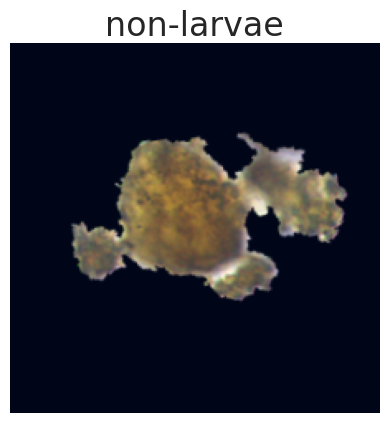

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Linear-13                   [-1, 64]       1,605,696
             ReLU-14                   

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=2e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6846 | Val Loss: 0.7067 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6253 | Val Loss: 0.6654 | Train cohen_kappa_fn: 0.0875 | Val cohen_kappa_fn: 0.0711 | Train f1_fn: 0.3995 | Val f1_fn: 0.5365
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5883 | Val Loss: 0.6727 | Train cohen_kappa_fn: 0.2295 | Val cohen_kappa_fn: 0.0549 | Train f1_fn: 0.8931 | Val f1_fn: 0.9009
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.5858 | Val Loss: 0.5975 | Train cohen_kappa_fn: 0.1969 | Val cohen_kappa_fn: 0.2174 | Train f1_fn: 0.6634 | Val f1_fn: 0.7662
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5554 | Val Loss: 0.6315 | Train cohen_kappa_fn: 0.3193 | Val cohen_kappa_fn: 0.2562 | Train f1_fn: 0.8702 | Val f1_fn: 0.9094
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5211 | Val Loss: 0.5696 | Train cohen_kappa_fn: 0.2378 | Val cohen_kappa_fn: 0.2421 | Train f1_fn: 0.7199 | Val f1_fn: 0.8163
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5142 | Val Loss: 0.6004 | Train cohen_kappa_fn: 0.3065 | Val cohen_kappa_fn: 0.2820 | Train f1_fn: 0.8258 | Val f1_fn: 0.8729
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5010 | Val Loss: 0.5360 | Train cohen_kappa_fn: 0.2797 | Val cohen_kappa_fn: 0.2492 | Train f1_fn: 0.7658 | Val f1_fn: 0.8320
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5016 | Val Loss: 0.5966 | Train cohen_kappa_fn: 0.3740 | Val cohen_kappa_fn: 0.3735 | Train f1_fn: 0.8741 | Val f1_fn: 0.9041
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4849 | Val Loss: 0.5047 | Train cohen_kappa_fn: 0.2497 | Val cohen_kappa_fn: 0.2552 | Train f1_fn: 0.7160 | Val f1_fn: 0.7477
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4856 | Val Loss: 0.5769 | Train cohen_kappa_fn: 0.5100 | Val cohen_kappa_fn: 0.4228 | Train f1_fn: 0.9226 | Val f1_fn: 0.9371
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4701 | Val Loss: 0.4617 | Train cohen_kappa_fn: 0.2729 | Val cohen_kappa_fn: 0.3821 | Train f1_fn: 0.7603 | Val f1_fn: 0.8673
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4520 | Val Loss: 0.5015 | Train cohen_kappa_fn: 0.4792 | Val cohen_kappa_fn: 0.5186 | Train f1_fn: 0.8901 | Val f1_fn: 0.9393
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.4506 | Val Loss: 0.4354 | Train cohen_kappa_fn: 0.3268 | Val cohen_kappa_fn: 0.4360 | Train f1_fn: 0.7848 | Val f1_fn: 0.8819
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.4250 | Val Loss: 0.4929 | Train cohen_kappa_fn: 0.4740 | Val cohen_kappa_fn: 0.4311 | Train f1_fn: 0.8975 | Val f1_fn: 0.9111
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3995 | Val Loss: 0.4521 | Train cohen_kappa_fn: 0.4158 | Val cohen_kappa_fn: 0.3813 | Train f1_fn: 0.8449 | Val f1_fn: 0.8344
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3964 | Val Loss: 0.4698 | Train cohen_kappa_fn: 0.6082 | Val cohen_kappa_fn: 0.4170 | Train f1_fn: 0.9279 | Val f1_fn: 0.8977
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.3907 | Val Loss: 0.4254 | Train cohen_kappa_fn: 0.5536 | Val cohen_kappa_fn: 0.4596 | Train f1_fn: 0.9039 | Val f1_fn: 0.8906
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3814 | Val Loss: 0.4133 | Train cohen_kappa_fn: 0.5261 | Val cohen_kappa_fn: 0.4914 | Train f1_fn: 0.8921 | Val f1_fn: 0.8988
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.3596 | Val Loss: 0.4065 | Train cohen_kappa_fn: 0.5098 | Val cohen_kappa_fn: 0.5250 | Train f1_fn: 0.8858 | Val f1_fn: 0.9167
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.3665 | Val Loss: 0.4105 | Train cohen_kappa_fn: 0.5819 | Val cohen_kappa_fn: 0.5987 | Train f1_fn: 0.9124 | Val f1_fn: 0.9458
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.3384 | Val Loss: 0.3810 | Train cohen_kappa_fn: 0.5403 | Val cohen_kappa_fn: 0.6606 | Train f1_fn: 0.8953 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.3519 | Val Loss: 0.3901 | Train cohen_kappa_fn: 0.6326 | Val cohen_kappa_fn: 0.6606 | Train f1_fn: 0.9256 | Val f1_fn: 0.9506
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.3513 | Val Loss: 0.3845 | Train cohen_kappa_fn: 0.5873 | Val cohen_kappa_fn: 0.4627 | Train f1_fn: 0.9141 | Val f1_fn: 0.8827
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.3287 | Val Loss: 0.3683 | Train cohen_kappa_fn: 0.5709 | Val cohen_kappa_fn: 0.4816 | Train f1_fn: 0.9079 | Val f1_fn: 0.8840
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.3367 | Val Loss: 0.3586 | Train cohen_kappa_fn: 0.6672 | Val cohen_kappa_fn: 0.6867 | Train f1_fn: 0.9376 | Val f1_fn: 0.9520
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.3364 | Val Loss: 0.3298 | Train cohen_kappa_fn: 0.5905 | Val cohen_kappa_fn: 0.6798 | Train f1_fn: 0.9118 | Val f1_fn: 0.9454
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.3135 | Val Loss: 0.3574 | Train cohen_kappa_fn: 0.5982 | Val cohen_kappa_fn: 0.6815 | Train f1_fn: 0.9175 | Val f1_fn: 0.9522
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2831 | Val Loss: 0.3505 | Train cohen_kappa_fn: 0.5841 | Val cohen_kappa_fn: 0.5508 | Train f1_fn: 0.9123 | Val f1_fn: 0.9130
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2857 | Val Loss: 0.3501 | Train cohen_kappa_fn: 0.5991 | Val cohen_kappa_fn: 0.5297 | Train f1_fn: 0.9154 | Val f1_fn: 0.8990
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2817 | Val Loss: 0.3379 | Train cohen_kappa_fn: 0.6106 | Val cohen_kappa_fn: 0.5434 | Train f1_fn: 0.9167 | Val f1_fn: 0.9084
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2852 | Val Loss: 0.3290 | Train cohen_kappa_fn: 0.6895 | Val cohen_kappa_fn: 0.5779 | Train f1_fn: 0.9384 | Val f1_fn: 0.9189
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.2746 | Val Loss: 0.3242 | Train cohen_kappa_fn: 0.6299 | Val cohen_kappa_fn: 0.5494 | Train f1_fn: 0.9227 | Val f1_fn: 0.9080
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.2749 | Val Loss: 0.3185 | Train cohen_kappa_fn: 0.6059 | Val cohen_kappa_fn: 0.5836 | Train f1_fn: 0.9191 | Val f1_fn: 0.9186
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.2833 | Val Loss: 0.3173 | Train cohen_kappa_fn: 0.7217 | Val cohen_kappa_fn: 0.6329 | Train f1_fn: 0.9495 | Val f1_fn: 0.9356
  🔥 New best model saved!


📘 Epoch 36 | Train Loss: 0.2747 | Val Loss: 0.3070 | Train cohen_kappa_fn: 0.6585 | Val cohen_kappa_fn: 0.6225 | Train f1_fn: 0.9342 | Val f1_fn: 0.9313
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.2892 | Val Loss: 0.3076 | Train cohen_kappa_fn: 0.6822 | Val cohen_kappa_fn: 0.6545 | Train f1_fn: 0.9398 | Val f1_fn: 0.9394
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.2593 | Val Loss: 0.3048 | Train cohen_kappa_fn: 0.6953 | Val cohen_kappa_fn: 0.6662 | Train f1_fn: 0.9421 | Val f1_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.2664 | Val Loss: 0.2970 | Train cohen_kappa_fn: 0.6795 | Val cohen_kappa_fn: 0.6486 | Train f1_fn: 0.9380 | Val f1_fn: 0.9349
  🔥 New best model saved!


📘 Epoch 40 | Train Loss: 0.2716 | Val Loss: 0.2957 | Train cohen_kappa_fn: 0.6768 | Val cohen_kappa_fn: 0.7062 | Train f1_fn: 0.9361 | Val f1_fn: 0.9513
  🔥 New best model saved!


📘 Epoch 41 | Train Loss: 0.2509 | Val Loss: 0.2942 | Train cohen_kappa_fn: 0.6513 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9316 | Val f1_fn: 0.9470
  🔥 New best model saved!


📘 Epoch 42 | Train Loss: 0.2636 | Val Loss: 0.2934 | Train cohen_kappa_fn: 0.6840 | Val cohen_kappa_fn: 0.7019 | Train f1_fn: 0.9397 | Val f1_fn: 0.9492
  🔥 New best model saved!


📘 Epoch 43 | Train Loss: 0.2641 | Val Loss: 0.2934 | Train cohen_kappa_fn: 0.7165 | Val cohen_kappa_fn: 0.7245 | Train f1_fn: 0.9469 | Val f1_fn: 0.9552
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.2459 | Val Loss: 0.2891 | Train cohen_kappa_fn: 0.6689 | Val cohen_kappa_fn: 0.6973 | Train f1_fn: 0.9346 | Val f1_fn: 0.9493
  🔥 New best model saved!


📘 Epoch 45 | Train Loss: 0.2767 | Val Loss: 0.2895 | Train cohen_kappa_fn: 0.6751 | Val cohen_kappa_fn: 0.6892 | Train f1_fn: 0.9362 | Val f1_fn: 0.9450
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.2538 | Val Loss: 0.2893 | Train cohen_kappa_fn: 0.6499 | Val cohen_kappa_fn: 0.6408 | Train f1_fn: 0.9286 | Val f1_fn: 0.9328
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.2723 | Val Loss: 0.2923 | Train cohen_kappa_fn: 0.6317 | Val cohen_kappa_fn: 0.6331 | Train f1_fn: 0.9246 | Val f1_fn: 0.9308
  ❄️ No improvement, model won't be saved!


📘 Epoch 48 | Train Loss: 0.2552 | Val Loss: 0.2930 | Train cohen_kappa_fn: 0.6725 | Val cohen_kappa_fn: 0.6435 | Train f1_fn: 0.9344 | Val f1_fn: 0.9351
  ❄️ No improvement, model won't be saved!


📘 Epoch 49 | Train Loss: 0.2700 | Val Loss: 0.2974 | Train cohen_kappa_fn: 0.6857 | Val cohen_kappa_fn: 0.6577 | Train f1_fn: 0.9396 | Val f1_fn: 0.9416
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


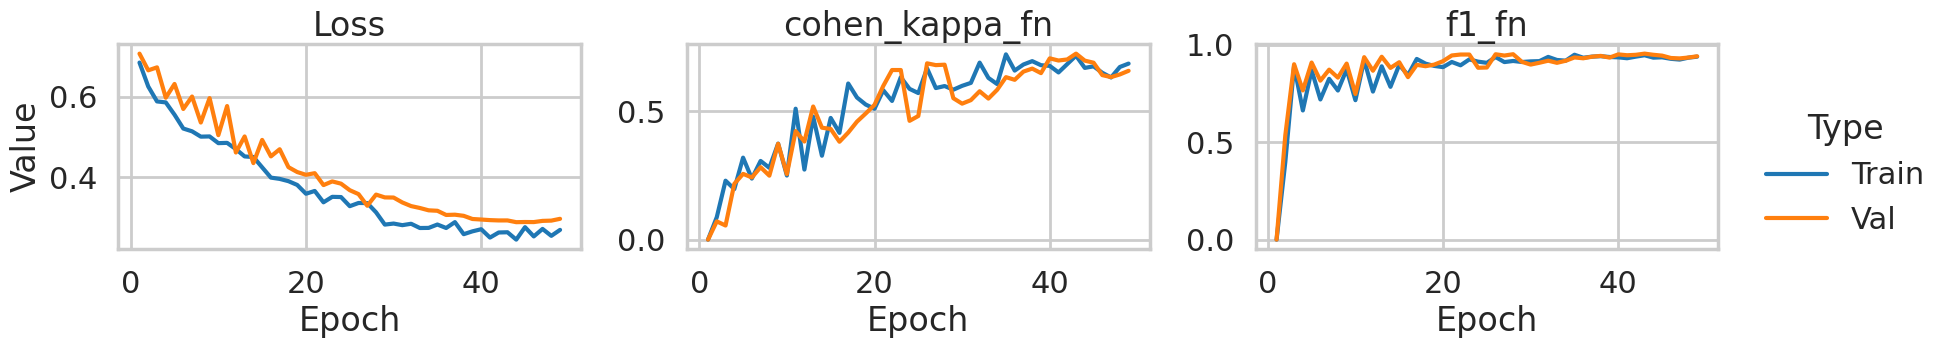

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.3005 | Test cohen_kappa_fn: 0.7034 | Test f1_fn: 0.9499


#### Visualization

In [14]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

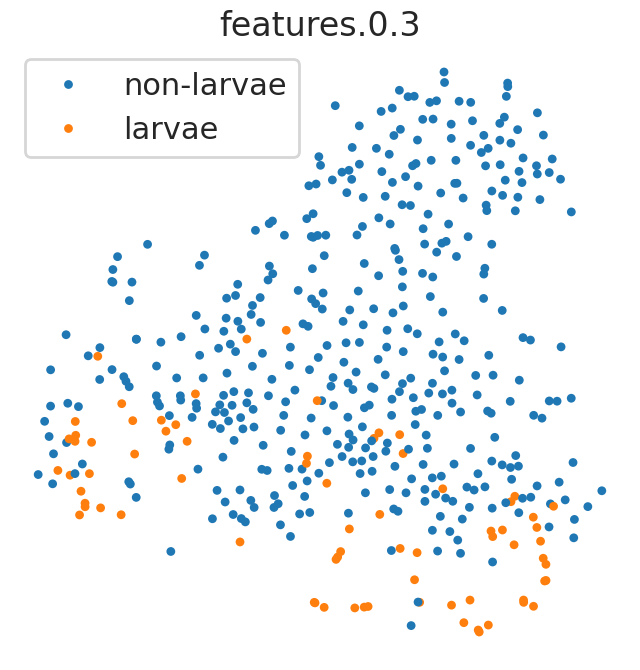

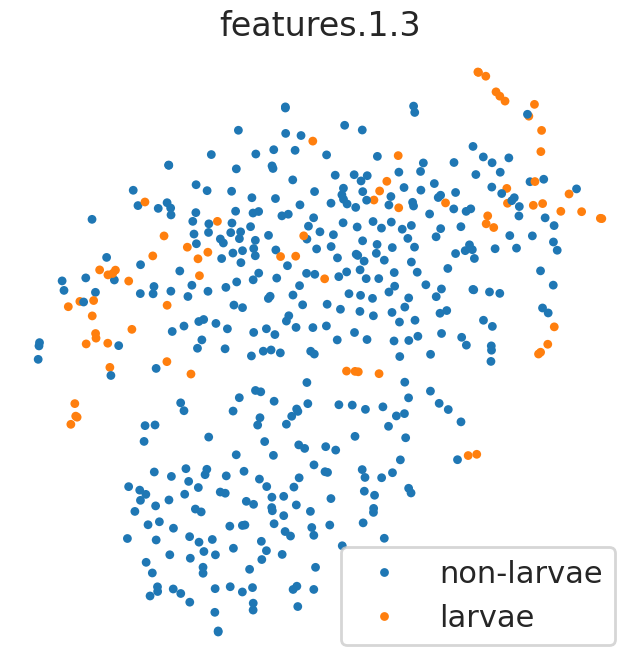

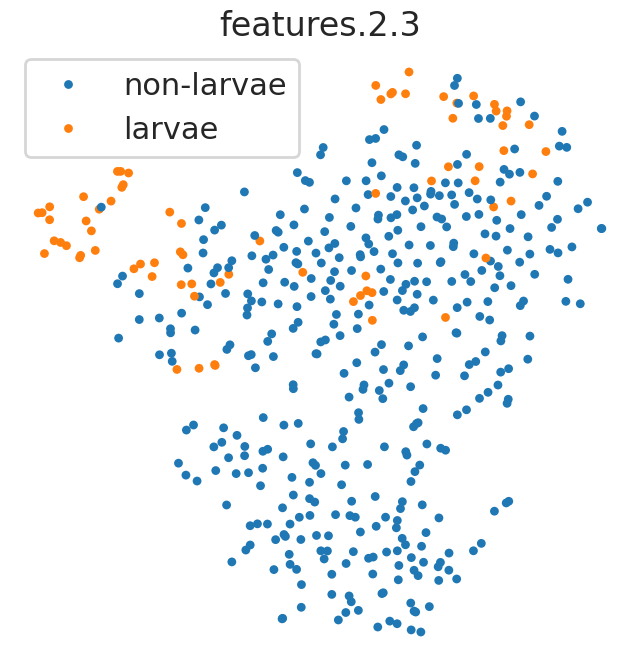

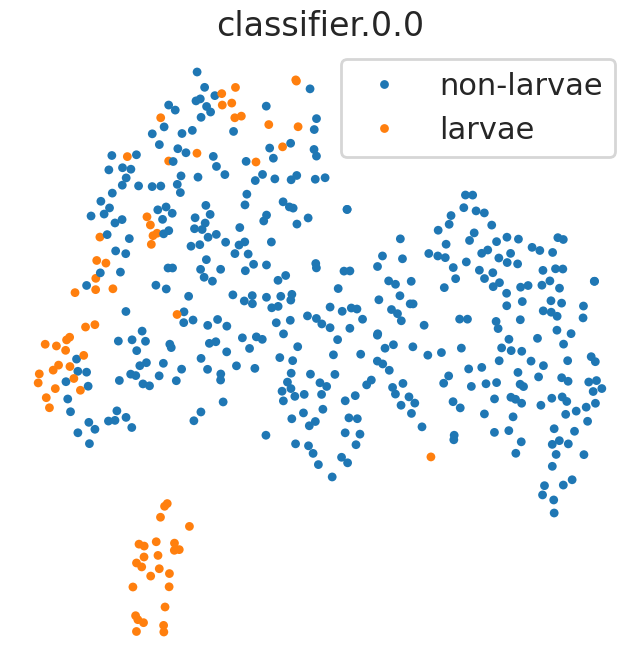

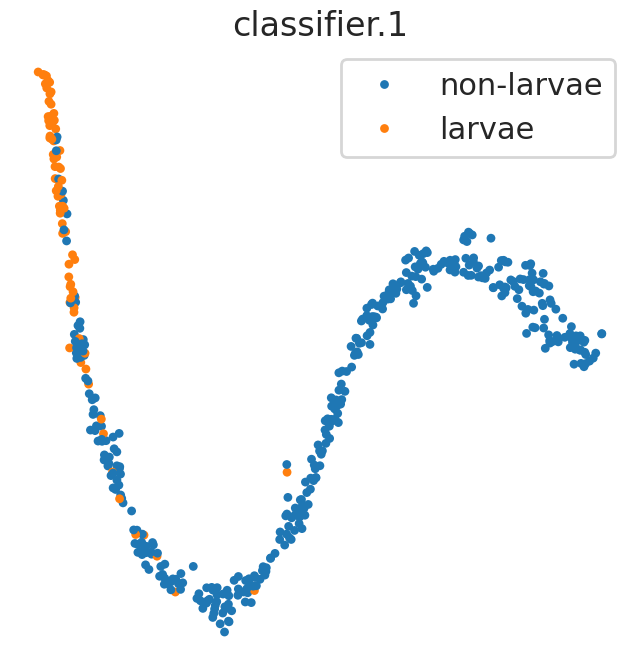

In [15]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


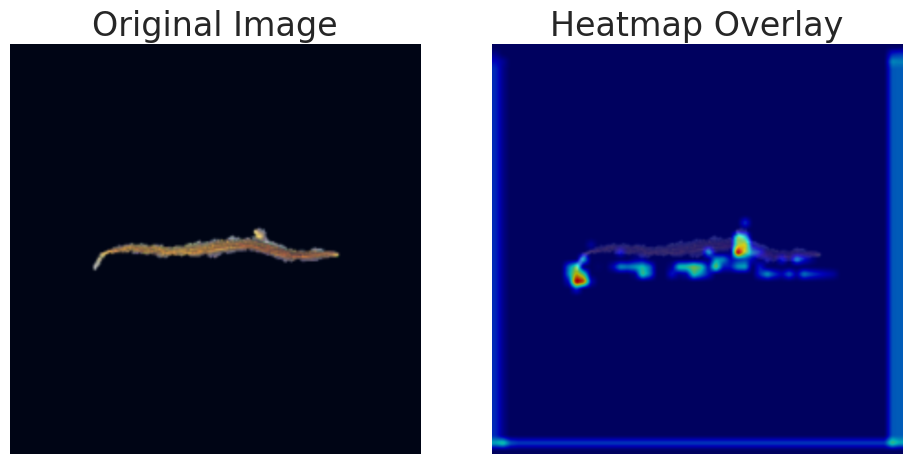

  Generating heatmap for Larvae...
  Predicted label is Larvae!


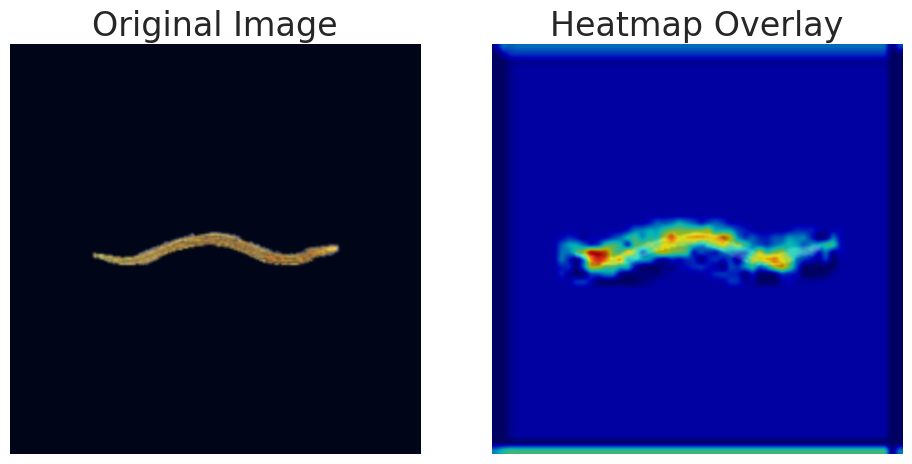

In [16]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [17]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [18]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=2e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [19]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6802 | Val Loss: 0.6861 | Train cohen_kappa_fn: 0.0615 | Val cohen_kappa_fn: 0.0980 | Train f1_fn: 0.3079 | Val f1_fn: 0.4973
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6438 | Val Loss: 0.6718 | Train cohen_kappa_fn: 0.1340 | Val cohen_kappa_fn: 0.0408 | Train f1_fn: 0.7391 | Val f1_fn: 0.8634
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6214 | Val Loss: 0.6420 | Train cohen_kappa_fn: 0.1672 | Val cohen_kappa_fn: 0.2355 | Train f1_fn: 0.6364 | Val f1_fn: 0.8303
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5902 | Val Loss: 0.6172 | Train cohen_kappa_fn: 0.2461 | Val cohen_kappa_fn: 0.3012 | Train f1_fn: 0.7309 | Val f1_fn: 0.8930
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5474 | Val Loss: 0.6269 | Train cohen_kappa_fn: 0.3497 | Val cohen_kappa_fn: 0.1947 | Train f1_fn: 0.8431 | Val f1_fn: 0.9065
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5110 | Val Loss: 0.5382 | Train cohen_kappa_fn: 0.3038 | Val cohen_kappa_fn: 0.3929 | Train f1_fn: 0.7495 | Val f1_fn: 0.8718
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4564 | Val Loss: 0.4962 | Train cohen_kappa_fn: 0.4504 | Val cohen_kappa_fn: 0.4945 | Train f1_fn: 0.8576 | Val f1_fn: 0.9202
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4067 | Val Loss: 0.4530 | Train cohen_kappa_fn: 0.5628 | Val cohen_kappa_fn: 0.5340 | Train f1_fn: 0.9043 | Val f1_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3675 | Val Loss: 0.5409 | Train cohen_kappa_fn: 0.6582 | Val cohen_kappa_fn: 0.4887 | Train f1_fn: 0.9492 | Val f1_fn: 0.9399
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4107 | Val Loss: 0.4062 | Train cohen_kappa_fn: 0.2547 | Val cohen_kappa_fn: 0.3293 | Train f1_fn: 0.6925 | Val f1_fn: 0.7586
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3549 | Val Loss: 0.3420 | Train cohen_kappa_fn: 0.7048 | Val cohen_kappa_fn: 0.6493 | Train f1_fn: 0.9465 | Val f1_fn: 0.9396
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3170 | Val Loss: 0.3060 | Train cohen_kappa_fn: 0.6394 | Val cohen_kappa_fn: 0.6233 | Train f1_fn: 0.9262 | Val f1_fn: 0.9264
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2677 | Val Loss: 0.3580 | Train cohen_kappa_fn: 0.7392 | Val cohen_kappa_fn: 0.6704 | Train f1_fn: 0.9609 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2900 | Val Loss: 0.2851 | Train cohen_kappa_fn: 0.5893 | Val cohen_kappa_fn: 0.5173 | Train f1_fn: 0.9056 | Val f1_fn: 0.8920
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2644 | Val Loss: 0.2717 | Train cohen_kappa_fn: 0.6861 | Val cohen_kappa_fn: 0.6256 | Train f1_fn: 0.9386 | Val f1_fn: 0.9287
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2789 | Val Loss: 0.2709 | Train cohen_kappa_fn: 0.6203 | Val cohen_kappa_fn: 0.6160 | Train f1_fn: 0.9161 | Val f1_fn: 0.9243
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2657 | Val Loss: 0.2623 | Train cohen_kappa_fn: 0.6765 | Val cohen_kappa_fn: 0.6486 | Train f1_fn: 0.9331 | Val f1_fn: 0.9349
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2339 | Val Loss: 0.3161 | Train cohen_kappa_fn: 0.7953 | Val cohen_kappa_fn: 0.7206 | Train f1_fn: 0.9653 | Val f1_fn: 0.9576
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2442 | Val Loss: 0.2749 | Train cohen_kappa_fn: 0.7407 | Val cohen_kappa_fn: 0.6628 | Train f1_fn: 0.9505 | Val f1_fn: 0.9414
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2396 | Val Loss: 0.2873 | Train cohen_kappa_fn: 0.7878 | Val cohen_kappa_fn: 0.6968 | Train f1_fn: 0.9628 | Val f1_fn: 0.9517
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1927 | Val Loss: 0.3074 | Train cohen_kappa_fn: 0.8056 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9677 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1753 | Val Loss: 0.2508 | Train cohen_kappa_fn: 0.6898 | Val cohen_kappa_fn: 0.6535 | Train f1_fn: 0.9374 | Val f1_fn: 0.9346
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2118 | Val Loss: 0.2543 | Train cohen_kappa_fn: 0.7631 | Val cohen_kappa_fn: 0.7063 | Train f1_fn: 0.9563 | Val f1_fn: 0.9490
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1997 | Val Loss: 0.2439 | Train cohen_kappa_fn: 0.6961 | Val cohen_kappa_fn: 0.6613 | Train f1_fn: 0.9380 | Val f1_fn: 0.9367
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1816 | Val Loss: 0.2352 | Train cohen_kappa_fn: 0.7455 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9513 | Val f1_fn: 0.9470
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1728 | Val Loss: 0.2409 | Train cohen_kappa_fn: 0.6091 | Val cohen_kappa_fn: 0.6190 | Train f1_fn: 0.9116 | Val f1_fn: 0.9216
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1674 | Val Loss: 0.2702 | Train cohen_kappa_fn: 0.8358 | Val cohen_kappa_fn: 0.7802 | Train f1_fn: 0.9721 | Val f1_fn: 0.9646
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1605 | Val Loss: 0.2352 | Train cohen_kappa_fn: 0.6992 | Val cohen_kappa_fn: 0.6583 | Train f1_fn: 0.9389 | Val f1_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1810 | Val Loss: 0.2422 | Train cohen_kappa_fn: 0.7964 | Val cohen_kappa_fn: 0.7514 | Train f1_fn: 0.9634 | Val f1_fn: 0.9588
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1513 | Val Loss: 0.2682 | Train cohen_kappa_fn: 0.8142 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9683 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1650 | Val Loss: 0.2819 | Train cohen_kappa_fn: 0.8378 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9729 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1638 | Val Loss: 0.2536 | Train cohen_kappa_fn: 0.8138 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9674 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1541 | Val Loss: 0.2425 | Train cohen_kappa_fn: 0.8089 | Val cohen_kappa_fn: 0.7802 | Train f1_fn: 0.9666 | Val f1_fn: 0.9646
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


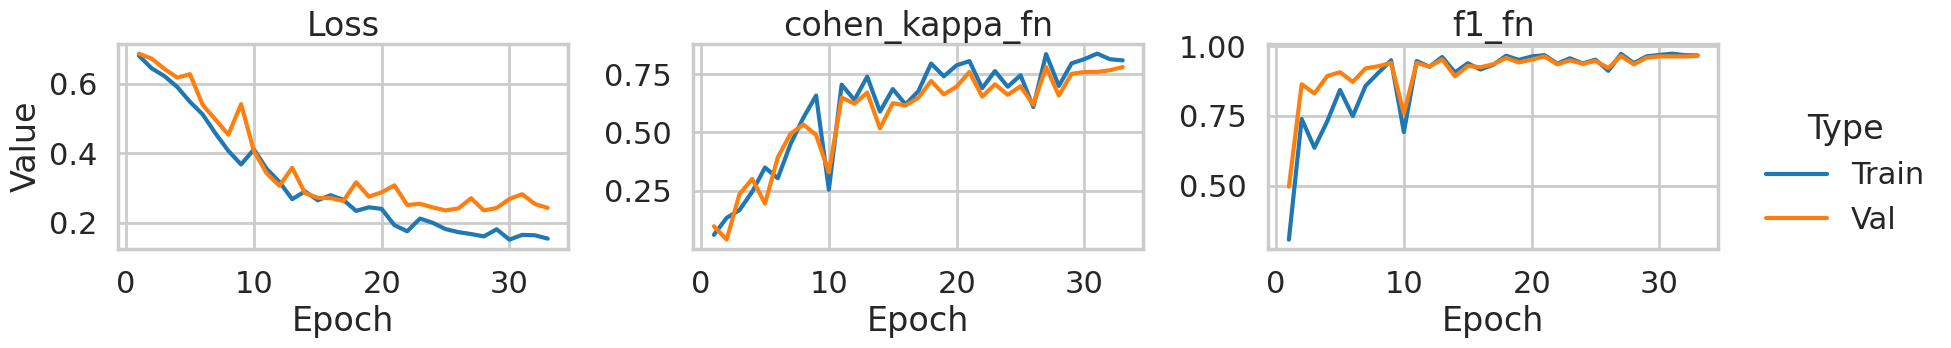

In [20]:
trainer_cnn_1.plot_epochs()

In [21]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2290 | Test cohen_kappa_fn: 0.7006 | Test f1_fn: 0.9484


#### Visualization

In [22]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

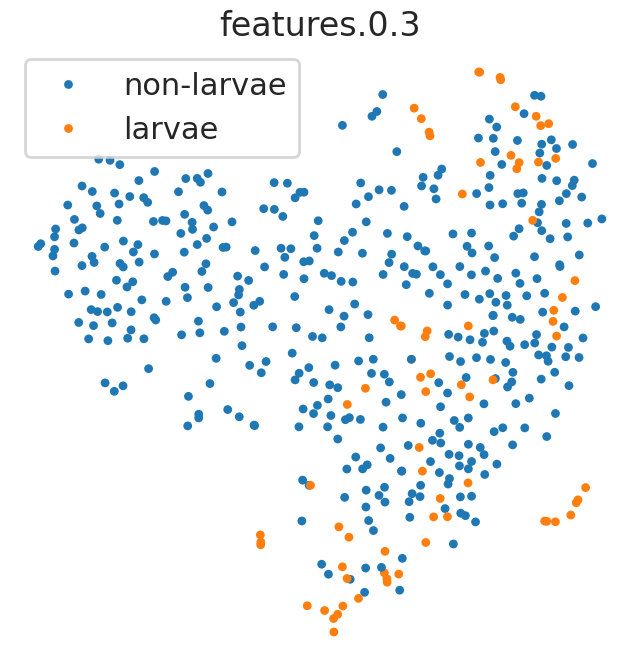

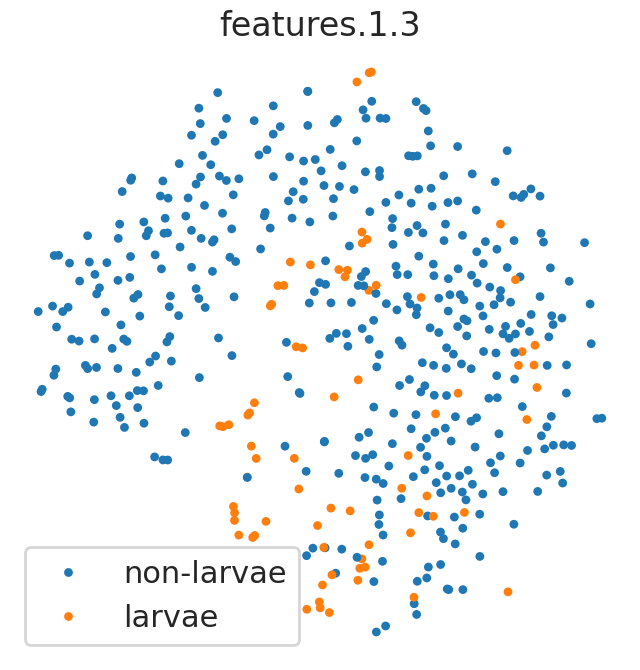

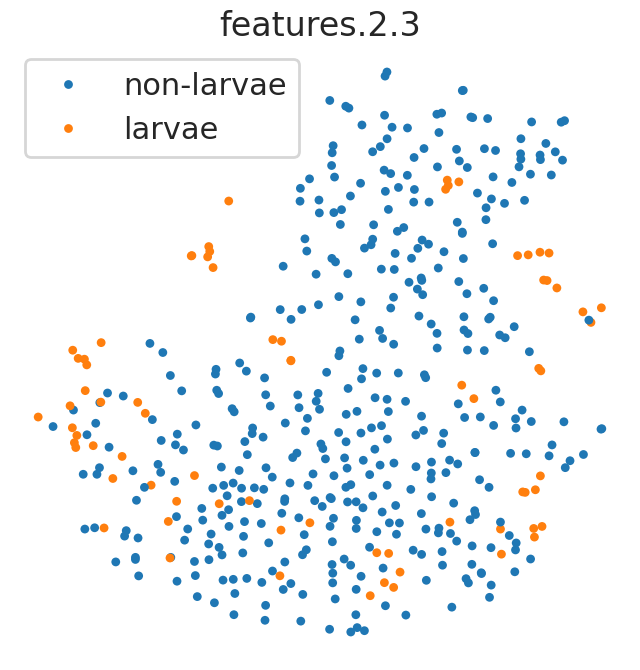

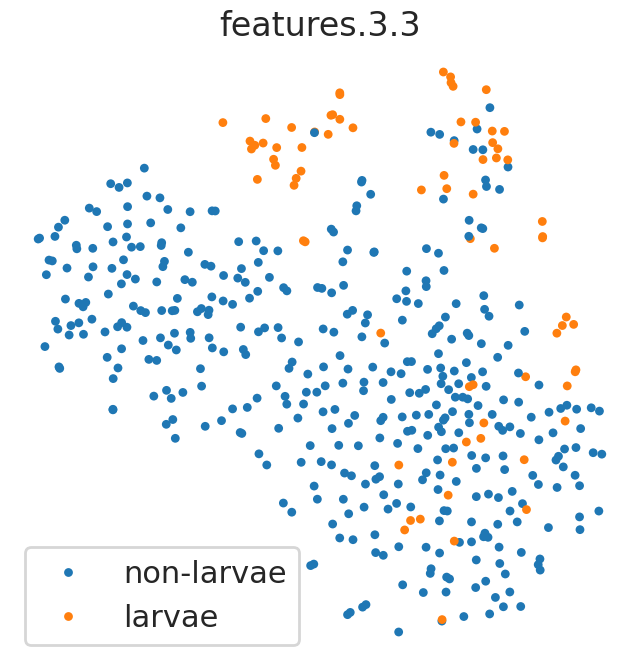

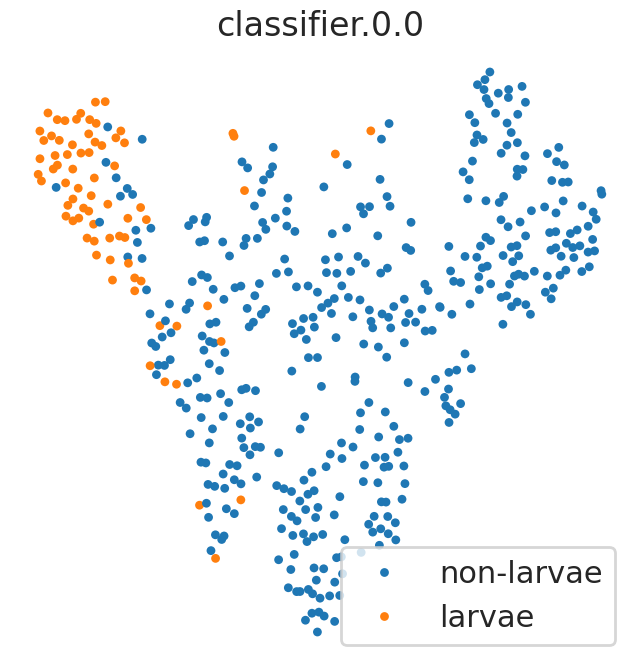

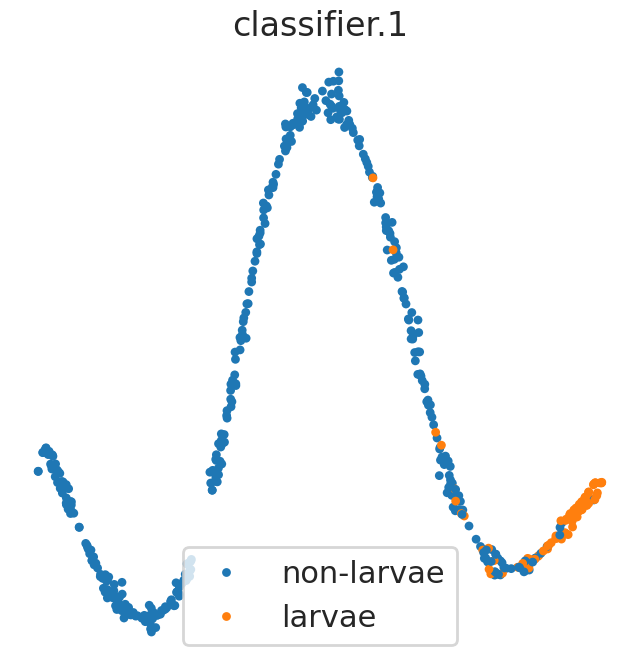

In [23]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


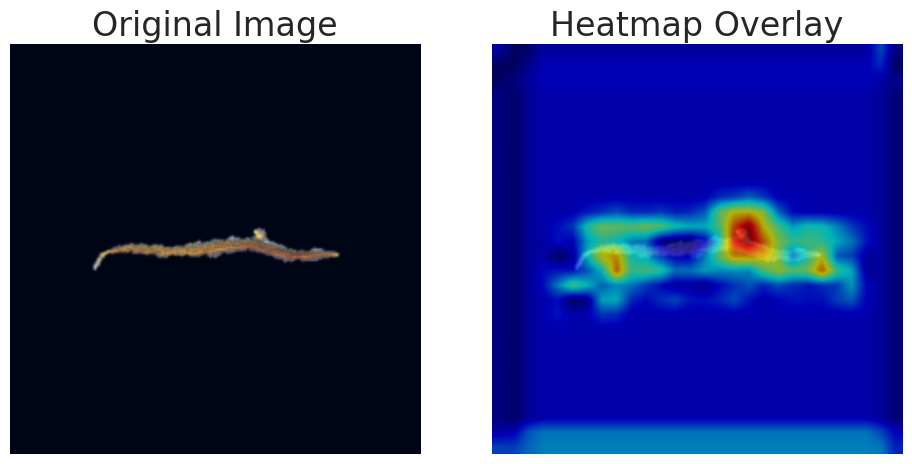

  Generating heatmap for Larvae...
  Predicted label is Larvae!


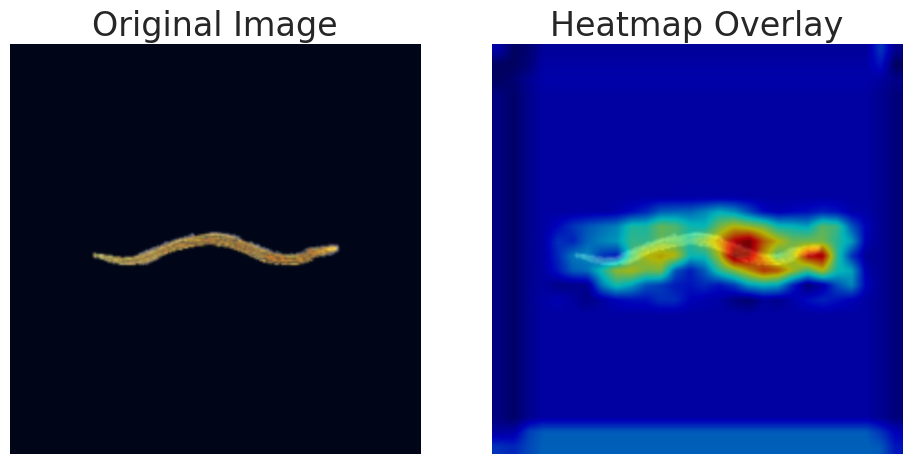

In [24]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [25]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [26]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=2e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [27]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6705 | Val Loss: 0.6650 | Train cohen_kappa_fn: 0.0663 | Val cohen_kappa_fn: 0.1159 | Train f1_fn: 0.3247 | Val f1_fn: 0.4889
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6246 | Val Loss: 0.6464 | Train cohen_kappa_fn: 0.2720 | Val cohen_kappa_fn: 0.1148 | Train f1_fn: 0.8846 | Val f1_fn: 0.9059
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5852 | Val Loss: 0.5877 | Train cohen_kappa_fn: 0.2101 | Val cohen_kappa_fn: 0.3113 | Train f1_fn: 0.7010 | Val f1_fn: 0.8434
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5130 | Val Loss: 0.5416 | Train cohen_kappa_fn: 0.3019 | Val cohen_kappa_fn: 0.3484 | Train f1_fn: 0.7582 | Val f1_fn: 0.8566
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4819 | Val Loss: 0.4794 | Train cohen_kappa_fn: 0.2608 | Val cohen_kappa_fn: 0.3656 | Train f1_fn: 0.7210 | Val f1_fn: 0.8302
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4429 | Val Loss: 0.4517 | Train cohen_kappa_fn: 0.3712 | Val cohen_kappa_fn: 0.4242 | Train f1_fn: 0.8202 | Val f1_fn: 0.8669
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4163 | Val Loss: 0.4266 | Train cohen_kappa_fn: 0.2845 | Val cohen_kappa_fn: 0.3573 | Train f1_fn: 0.7349 | Val f1_fn: 0.7911
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4526 | Val Loss: 0.5670 | Train cohen_kappa_fn: 0.5993 | Val cohen_kappa_fn: 0.4138 | Train f1_fn: 0.9439 | Val f1_fn: 0.9269
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.4122 | Val Loss: 0.4485 | Train cohen_kappa_fn: 0.2389 | Val cohen_kappa_fn: 0.2486 | Train f1_fn: 0.6777 | Val f1_fn: 0.6877
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.3810 | Val Loss: 0.4388 | Train cohen_kappa_fn: 0.6430 | Val cohen_kappa_fn: 0.6104 | Train f1_fn: 0.9425 | Val f1_fn: 0.9433
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3340 | Val Loss: 0.3434 | Train cohen_kappa_fn: 0.4803 | Val cohen_kappa_fn: 0.4428 | Train f1_fn: 0.8662 | Val f1_fn: 0.8542
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3283 | Val Loss: 0.3347 | Train cohen_kappa_fn: 0.5826 | Val cohen_kappa_fn: 0.5113 | Train f1_fn: 0.9092 | Val f1_fn: 0.8924
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3154 | Val Loss: 0.3541 | Train cohen_kappa_fn: 0.3953 | Val cohen_kappa_fn: 0.3768 | Train f1_fn: 0.8147 | Val f1_fn: 0.8044
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2913 | Val Loss: 0.3127 | Train cohen_kappa_fn: 0.5960 | Val cohen_kappa_fn: 0.5174 | Train f1_fn: 0.9104 | Val f1_fn: 0.8946
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2771 | Val Loss: 0.3255 | Train cohen_kappa_fn: 0.6592 | Val cohen_kappa_fn: 0.5851 | Train f1_fn: 0.9331 | Val f1_fn: 0.9210
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2636 | Val Loss: 0.3287 | Train cohen_kappa_fn: 0.6260 | Val cohen_kappa_fn: 0.5000 | Train f1_fn: 0.9230 | Val f1_fn: 0.8826
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2509 | Val Loss: 0.3374 | Train cohen_kappa_fn: 0.5190 | Val cohen_kappa_fn: 0.3899 | Train f1_fn: 0.8784 | Val f1_fn: 0.8305
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2574 | Val Loss: 0.3087 | Train cohen_kappa_fn: 0.6310 | Val cohen_kappa_fn: 0.5418 | Train f1_fn: 0.9216 | Val f1_fn: 0.9008
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2462 | Val Loss: 0.3111 | Train cohen_kappa_fn: 0.6450 | Val cohen_kappa_fn: 0.5766 | Train f1_fn: 0.9259 | Val f1_fn: 0.9165
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2468 | Val Loss: 0.3188 | Train cohen_kappa_fn: 0.6743 | Val cohen_kappa_fn: 0.5836 | Train f1_fn: 0.9343 | Val f1_fn: 0.9186
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2355 | Val Loss: 0.3371 | Train cohen_kappa_fn: 0.7358 | Val cohen_kappa_fn: 0.7201 | Train f1_fn: 0.9537 | Val f1_fn: 0.9554
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2340 | Val Loss: 0.2848 | Train cohen_kappa_fn: 0.7359 | Val cohen_kappa_fn: 0.6053 | Train f1_fn: 0.9498 | Val f1_fn: 0.9249
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1989 | Val Loss: 0.3442 | Train cohen_kappa_fn: 0.7771 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9632 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2143 | Val Loss: 0.2945 | Train cohen_kappa_fn: 0.7052 | Val cohen_kappa_fn: 0.5610 | Train f1_fn: 0.9415 | Val f1_fn: 0.9073
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2105 | Val Loss: 0.2834 | Train cohen_kappa_fn: 0.7781 | Val cohen_kappa_fn: 0.6515 | Train f1_fn: 0.9604 | Val f1_fn: 0.9371
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1985 | Val Loss: 0.2610 | Train cohen_kappa_fn: 0.7534 | Val cohen_kappa_fn: 0.6127 | Train f1_fn: 0.9548 | Val f1_fn: 0.9269
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.1836 | Val Loss: 0.2699 | Train cohen_kappa_fn: 0.7828 | Val cohen_kappa_fn: 0.7153 | Train f1_fn: 0.9621 | Val f1_fn: 0.9533
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1914 | Val Loss: 0.2829 | Train cohen_kappa_fn: 0.7979 | Val cohen_kappa_fn: 0.7449 | Train f1_fn: 0.9661 | Val f1_fn: 0.9613
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1713 | Val Loss: 0.2856 | Train cohen_kappa_fn: 0.8259 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9706 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1741 | Val Loss: 0.2898 | Train cohen_kappa_fn: 0.8277 | Val cohen_kappa_fn: 0.7630 | Train f1_fn: 0.9715 | Val f1_fn: 0.9630
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1820 | Val Loss: 0.2665 | Train cohen_kappa_fn: 0.7499 | Val cohen_kappa_fn: 0.6515 | Train f1_fn: 0.9540 | Val f1_fn: 0.9371
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


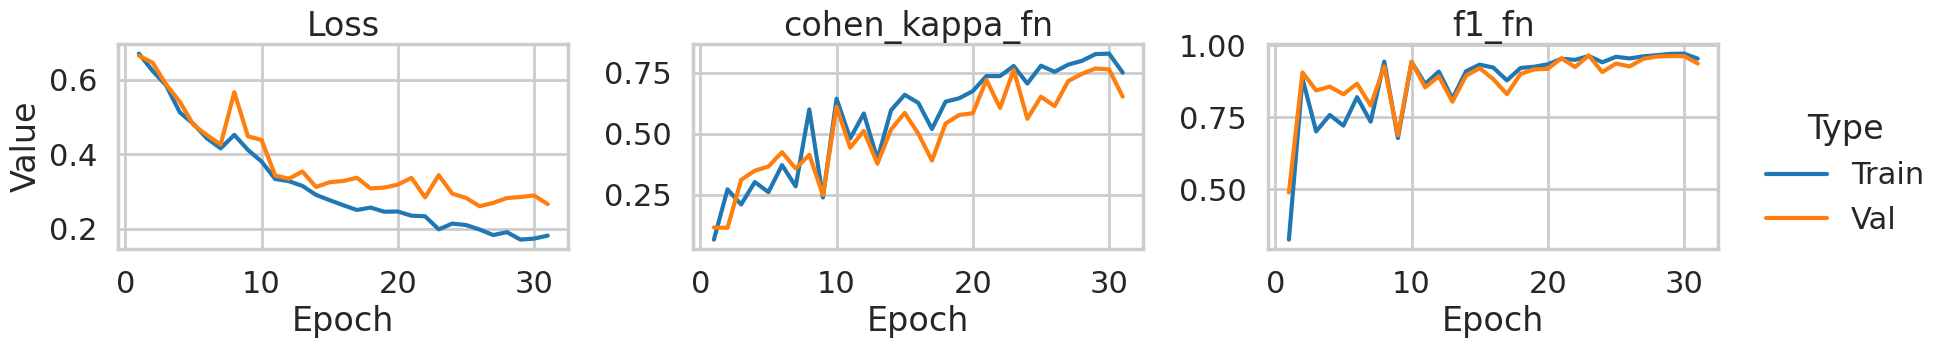

In [28]:
trainer_cnn_2.plot_epochs()

In [29]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2016 | Test cohen_kappa_fn: 0.7510 | Test f1_fn: 0.9541


#### Visualization

In [30]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

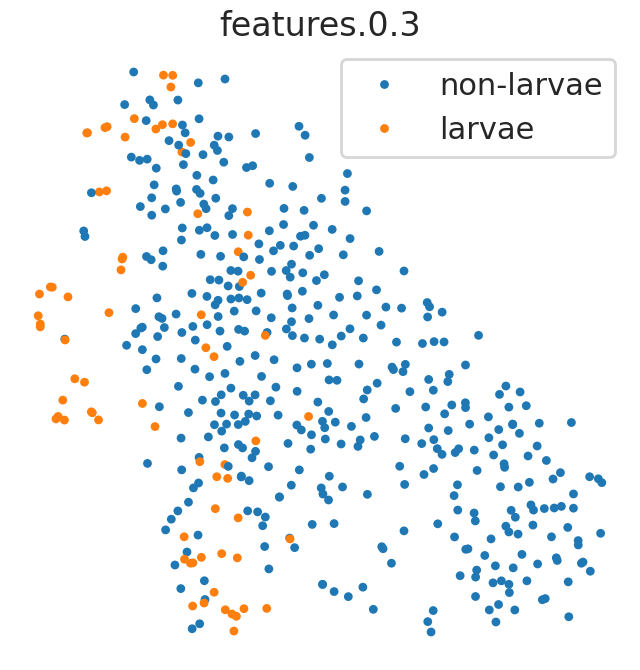

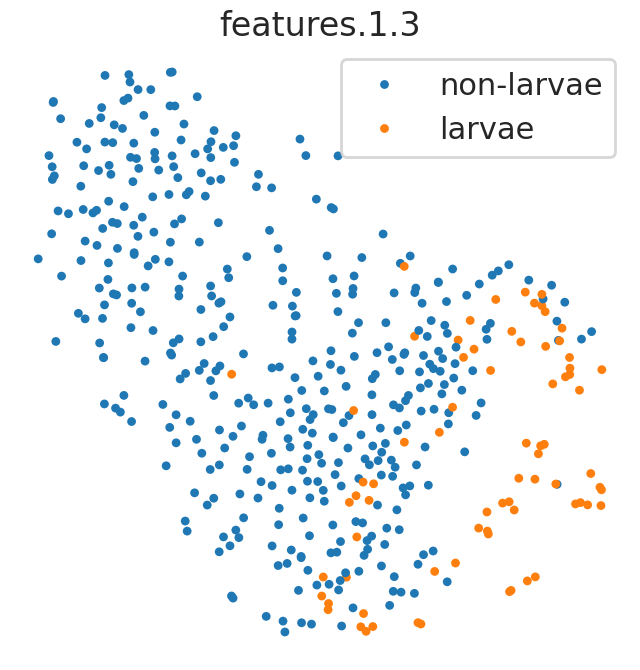

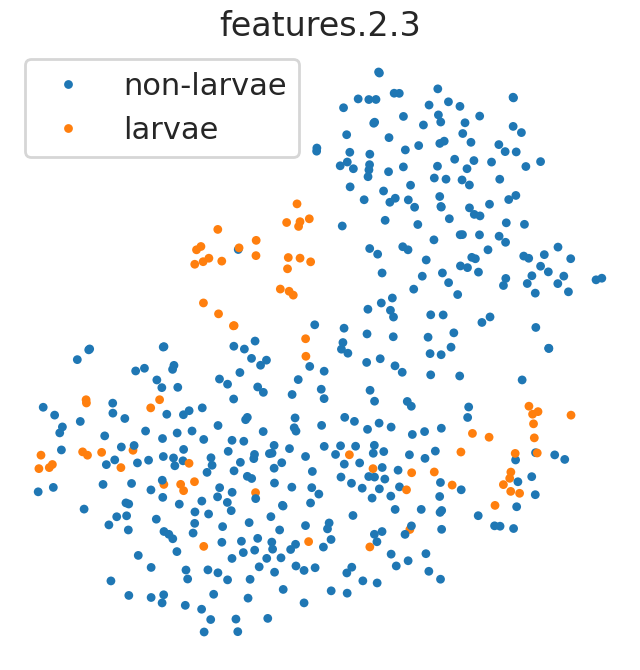

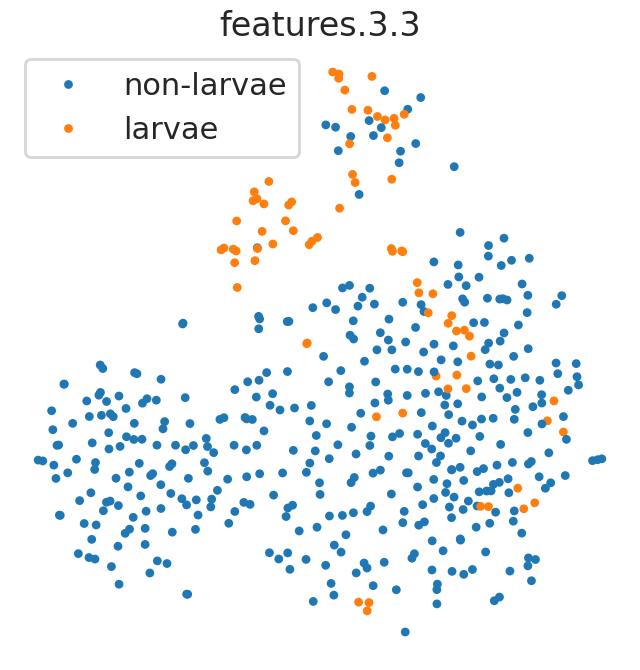

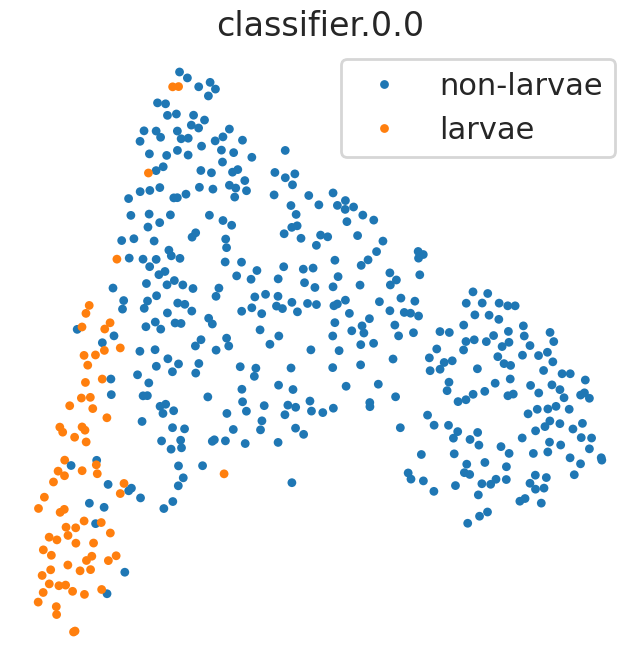

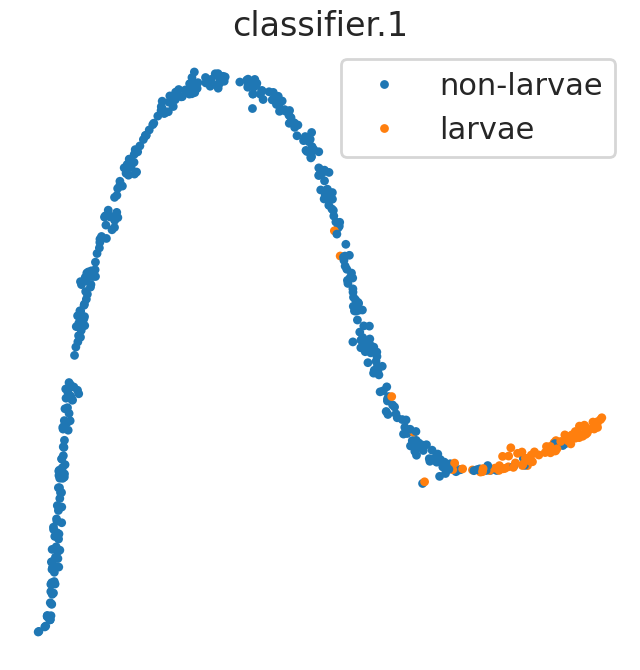

In [31]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


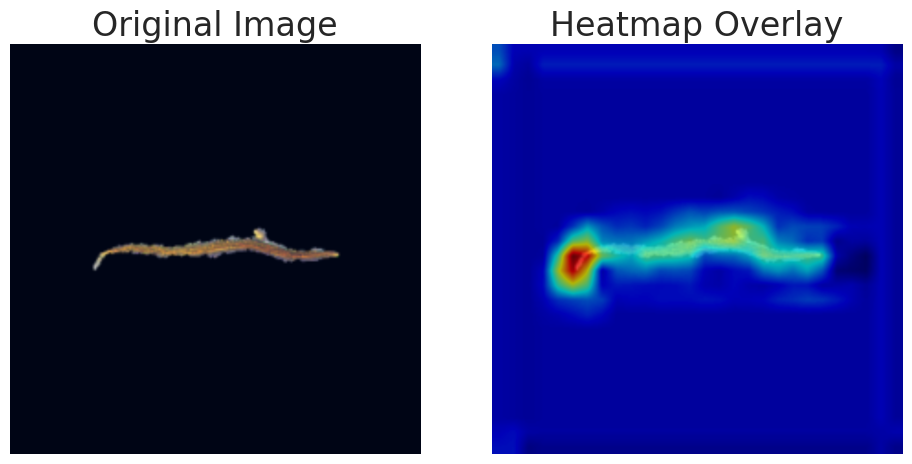

  Generating heatmap for Larvae...
  Predicted label is Larvae!


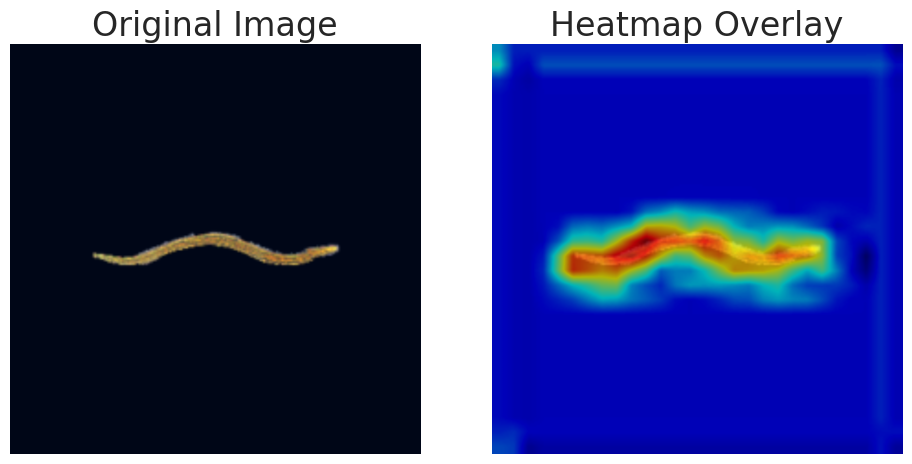

In [32]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [33]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          36,864
      BatchNorm2d-14          [-1, 128,

In [34]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=2e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-5)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [35]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 1.0048 | Val Loss: 0.6941 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6999 | Val Loss: 0.6878 | Train cohen_kappa_fn: 0.0651 | Val cohen_kappa_fn: -0.0067 | Train f1_fn: 0.7496 | Val f1_fn: 0.6928
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6837 | Val Loss: 0.6819 | Train cohen_kappa_fn: 0.0982 | Val cohen_kappa_fn: 0.0082 | Train f1_fn: 0.9067 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6643 | Val Loss: 0.6660 | Train cohen_kappa_fn: 0.1788 | Val cohen_kappa_fn: 0.0870 | Train f1_fn: 0.7419 | Val f1_fn: 0.8040
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6593 | Val Loss: 0.6515 | Train cohen_kappa_fn: 0.1578 | Val cohen_kappa_fn: 0.1200 | Train f1_fn: 0.7216 | Val f1_fn: 0.8173
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6273 | Val Loss: 0.6347 | Train cohen_kappa_fn: 0.2333 | Val cohen_kappa_fn: 0.2077 | Train f1_fn: 0.7373 | Val f1_fn: 0.8270
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6153 | Val Loss: 0.6172 | Train cohen_kappa_fn: 0.2159 | Val cohen_kappa_fn: 0.2329 | Train f1_fn: 0.7239 | Val f1_fn: 0.7916
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5876 | Val Loss: 0.6030 | Train cohen_kappa_fn: 0.2769 | Val cohen_kappa_fn: 0.2764 | Train f1_fn: 0.7986 | Val f1_fn: 0.8610
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5711 | Val Loss: 0.5627 | Train cohen_kappa_fn: 0.2394 | Val cohen_kappa_fn: 0.3197 | Train f1_fn: 0.7308 | Val f1_fn: 0.8233
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5453 | Val Loss: 0.5867 | Train cohen_kappa_fn: 0.3629 | Val cohen_kappa_fn: 0.3621 | Train f1_fn: 0.8615 | Val f1_fn: 0.9111
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.5021 | Val Loss: 0.4892 | Train cohen_kappa_fn: 0.2836 | Val cohen_kappa_fn: 0.3858 | Train f1_fn: 0.7559 | Val f1_fn: 0.8368
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4740 | Val Loss: 0.4489 | Train cohen_kappa_fn: 0.3859 | Val cohen_kappa_fn: 0.5532 | Train f1_fn: 0.8305 | Val f1_fn: 0.9202
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4641 | Val Loss: 0.4117 | Train cohen_kappa_fn: 0.3083 | Val cohen_kappa_fn: 0.5059 | Train f1_fn: 0.7430 | Val f1_fn: 0.8821
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4418 | Val Loss: 0.5362 | Train cohen_kappa_fn: 0.5976 | Val cohen_kappa_fn: 0.4767 | Train f1_fn: 0.9422 | Val f1_fn: 0.9422
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.4443 | Val Loss: 0.3935 | Train cohen_kappa_fn: 0.3905 | Val cohen_kappa_fn: 0.4893 | Train f1_fn: 0.8153 | Val f1_fn: 0.8753
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3995 | Val Loss: 0.3750 | Train cohen_kappa_fn: 0.5786 | Val cohen_kappa_fn: 0.6329 | Train f1_fn: 0.9053 | Val f1_fn: 0.9356
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3893 | Val Loss: 0.3616 | Train cohen_kappa_fn: 0.6404 | Val cohen_kappa_fn: 0.7296 | Train f1_fn: 0.9292 | Val f1_fn: 0.9573
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3480 | Val Loss: 0.3334 | Train cohen_kappa_fn: 0.5916 | Val cohen_kappa_fn: 0.6515 | Train f1_fn: 0.9138 | Val f1_fn: 0.9371
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3280 | Val Loss: 0.4226 | Train cohen_kappa_fn: 0.7195 | Val cohen_kappa_fn: 0.7274 | Train f1_fn: 0.9580 | Val f1_fn: 0.9640
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3138 | Val Loss: 0.3145 | Train cohen_kappa_fn: 0.6085 | Val cohen_kappa_fn: 0.5731 | Train f1_fn: 0.9137 | Val f1_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2926 | Val Loss: 0.3301 | Train cohen_kappa_fn: 0.7482 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9588 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2870 | Val Loss: 0.2983 | Train cohen_kappa_fn: 0.5988 | Val cohen_kappa_fn: 0.5720 | Train f1_fn: 0.9081 | Val f1_fn: 0.9066
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2584 | Val Loss: 0.3024 | Train cohen_kappa_fn: 0.7901 | Val cohen_kappa_fn: 0.7570 | Train f1_fn: 0.9655 | Val f1_fn: 0.9609
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2528 | Val Loss: 0.2857 | Train cohen_kappa_fn: 0.7317 | Val cohen_kappa_fn: 0.7107 | Train f1_fn: 0.9510 | Val f1_fn: 0.9511
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2430 | Val Loss: 0.2898 | Train cohen_kappa_fn: 0.8066 | Val cohen_kappa_fn: 0.6925 | Train f1_fn: 0.9667 | Val f1_fn: 0.9495
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2080 | Val Loss: 0.2719 | Train cohen_kappa_fn: 0.7519 | Val cohen_kappa_fn: 0.7197 | Train f1_fn: 0.9549 | Val f1_fn: 0.9531
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2117 | Val Loss: 0.2574 | Train cohen_kappa_fn: 0.7534 | Val cohen_kappa_fn: 0.6773 | Train f1_fn: 0.9548 | Val f1_fn: 0.9407
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2061 | Val Loss: 0.2677 | Train cohen_kappa_fn: 0.8014 | Val cohen_kappa_fn: 0.7019 | Train f1_fn: 0.9650 | Val f1_fn: 0.9492
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2028 | Val Loss: 0.2737 | Train cohen_kappa_fn: 0.7915 | Val cohen_kappa_fn: 0.7063 | Train f1_fn: 0.9636 | Val f1_fn: 0.9490
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2191 | Val Loss: 0.2614 | Train cohen_kappa_fn: 0.7820 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9602 | Val f1_fn: 0.9464
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1867 | Val Loss: 0.2512 | Train cohen_kappa_fn: 0.7356 | Val cohen_kappa_fn: 0.6784 | Train f1_fn: 0.9488 | Val f1_fn: 0.9382
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.1842 | Val Loss: 0.2531 | Train cohen_kappa_fn: 0.7903 | Val cohen_kappa_fn: 0.7024 | Train f1_fn: 0.9627 | Val f1_fn: 0.9443
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1672 | Val Loss: 0.2538 | Train cohen_kappa_fn: 0.7084 | Val cohen_kappa_fn: 0.6660 | Train f1_fn: 0.9424 | Val f1_fn: 0.9364
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1933 | Val Loss: 0.2519 | Train cohen_kappa_fn: 0.7856 | Val cohen_kappa_fn: 0.7064 | Train f1_fn: 0.9610 | Val f1_fn: 0.9466
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1867 | Val Loss: 0.2555 | Train cohen_kappa_fn: 0.8097 | Val cohen_kappa_fn: 0.7021 | Train f1_fn: 0.9656 | Val f1_fn: 0.9468
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1678 | Val Loss: 0.2454 | Train cohen_kappa_fn: 0.7892 | Val cohen_kappa_fn: 0.6981 | Train f1_fn: 0.9608 | Val f1_fn: 0.9446
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.1760 | Val Loss: 0.2651 | Train cohen_kappa_fn: 0.8248 | Val cohen_kappa_fn: 0.7197 | Train f1_fn: 0.9707 | Val f1_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1786 | Val Loss: 0.2646 | Train cohen_kappa_fn: 0.8063 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9658 | Val f1_fn: 0.9488
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.1682 | Val Loss: 0.2592 | Train cohen_kappa_fn: 0.7976 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9633 | Val f1_fn: 0.9488
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.1695 | Val Loss: 0.2675 | Train cohen_kappa_fn: 0.8368 | Val cohen_kappa_fn: 0.7151 | Train f1_fn: 0.9730 | Val f1_fn: 0.9509
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.1829 | Val Loss: 0.2628 | Train cohen_kappa_fn: 0.8063 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9658 | Val f1_fn: 0.9508
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


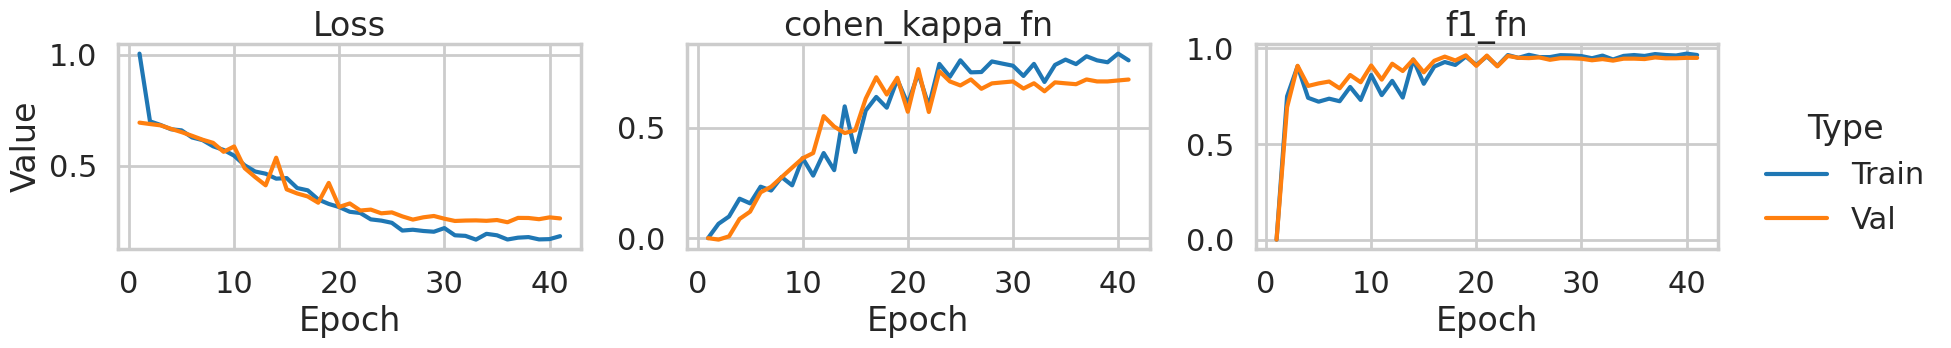

In [36]:
trainer_cnn_3.plot_epochs()

In [37]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2339 | Test cohen_kappa_fn: 0.7320 | Test f1_fn: 0.9518


#### Visualization

In [38]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

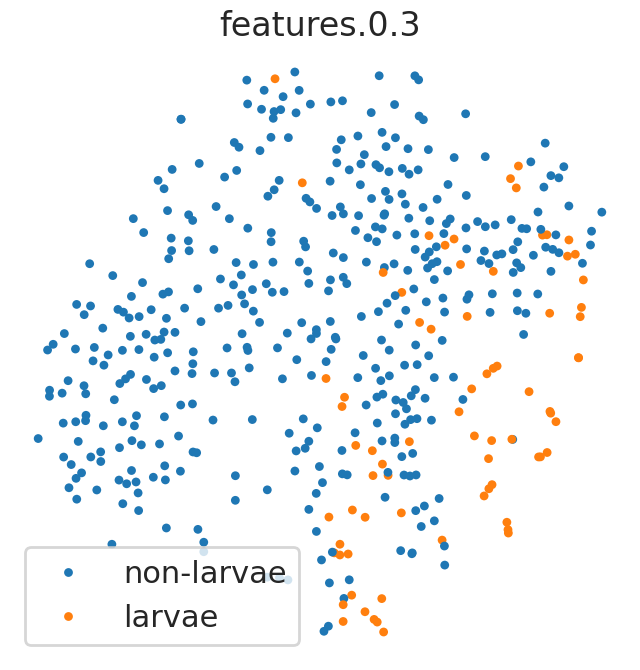

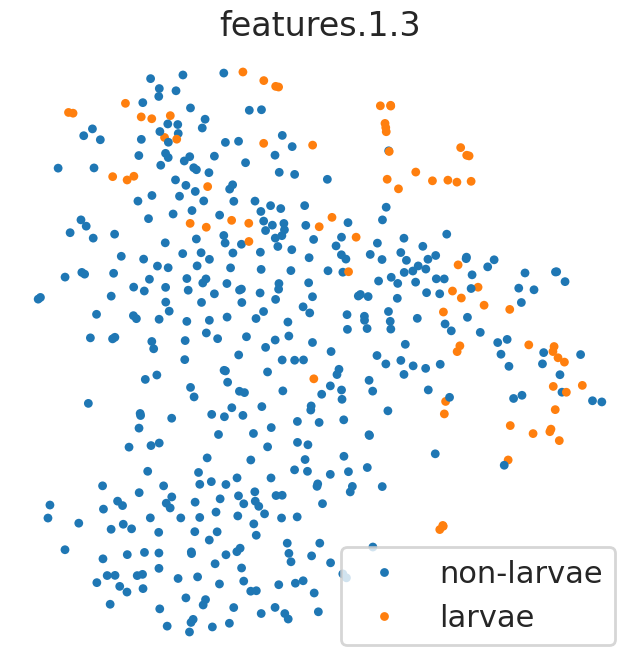

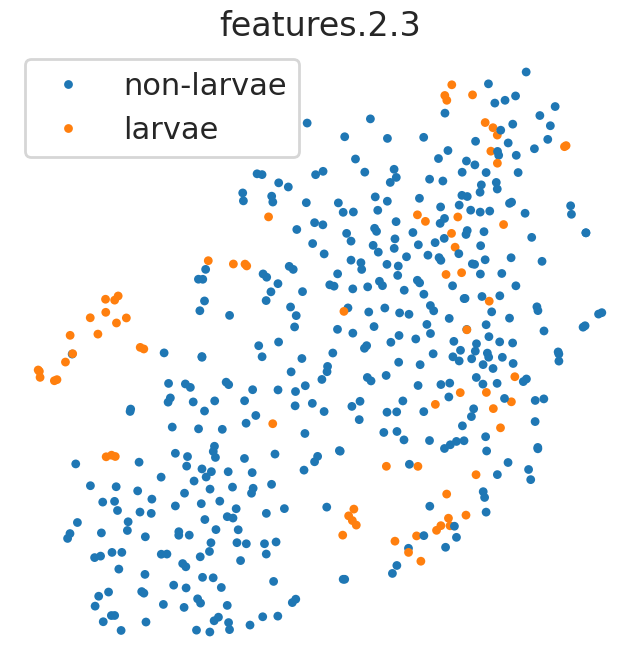

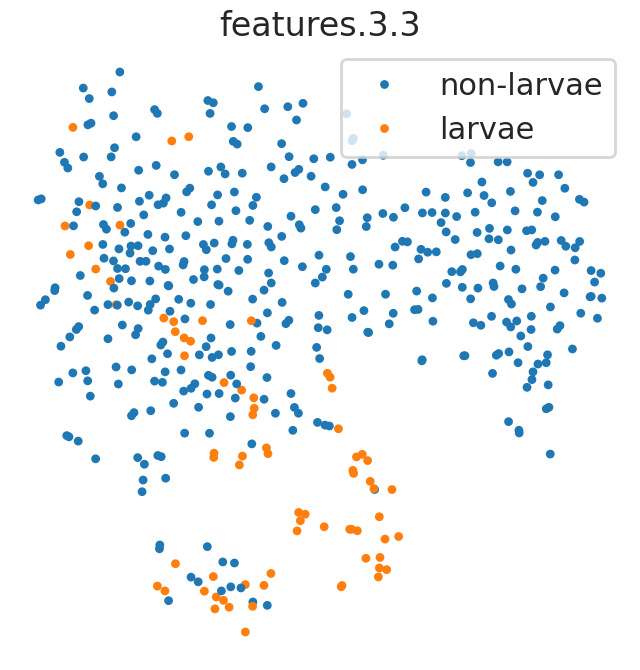

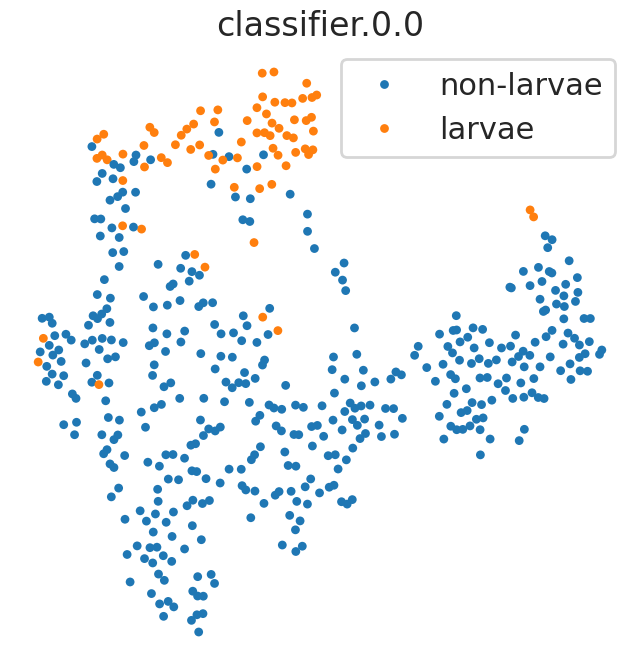

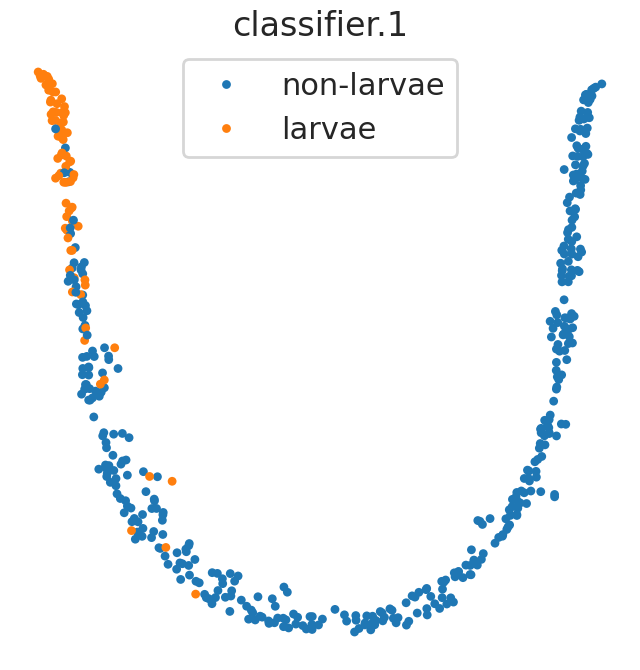

In [39]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


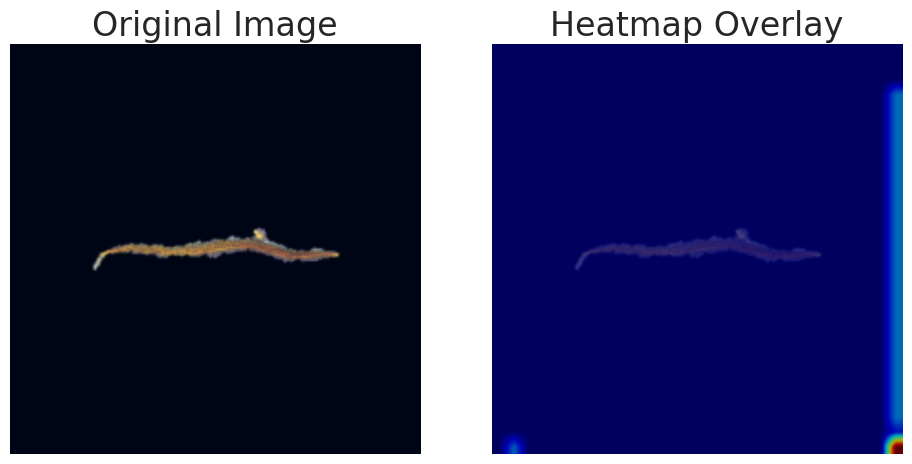

  Generating heatmap for Larvae...
  Predicted label is Larvae!


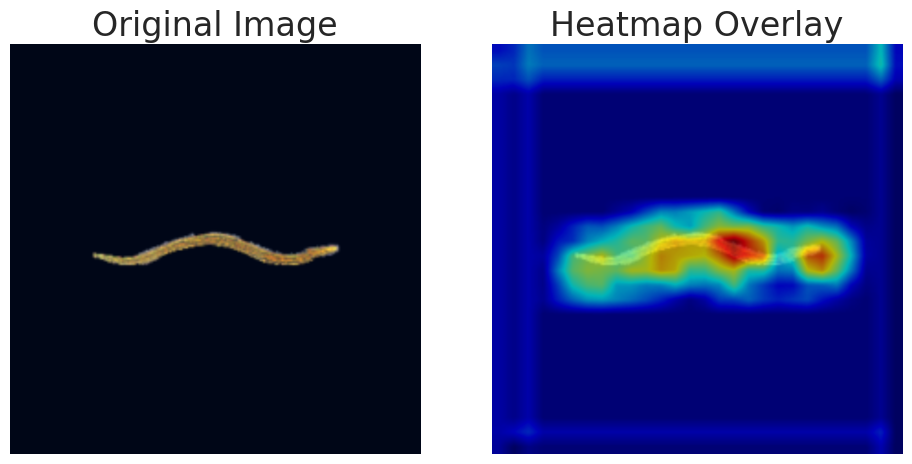

In [40]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [41]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,16],
    conv_channels=[8,16,32,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          36,864
      BatchNorm2d-14          [-1, 128,

In [42]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=2e-4)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=1e-5)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [43]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6913 | Val Loss: 0.6923 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6872 | Val Loss: 0.6893 | Train cohen_kappa_fn: 0.0137 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9171 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6776 | Val Loss: 0.6795 | Train cohen_kappa_fn: 0.1637 | Val cohen_kappa_fn: 0.0088 | Train f1_fn: 0.8610 | Val f1_fn: 0.8750
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6591 | Val Loss: 0.6598 | Train cohen_kappa_fn: 0.2523 | Val cohen_kappa_fn: 0.2061 | Train f1_fn: 0.7942 | Val f1_fn: 0.8000
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6327 | Val Loss: 0.6171 | Train cohen_kappa_fn: 0.2535 | Val cohen_kappa_fn: 0.2144 | Train f1_fn: 0.7379 | Val f1_fn: 0.7172
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5873 | Val Loss: 0.5530 | Train cohen_kappa_fn: 0.3372 | Val cohen_kappa_fn: 0.3488 | Train f1_fn: 0.7986 | Val f1_fn: 0.7956
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5188 | Val Loss: 0.4925 | Train cohen_kappa_fn: 0.3323 | Val cohen_kappa_fn: 0.3973 | Train f1_fn: 0.7865 | Val f1_fn: 0.8174
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4986 | Val Loss: 0.4474 | Train cohen_kappa_fn: 0.3013 | Val cohen_kappa_fn: 0.3729 | Train f1_fn: 0.7500 | Val f1_fn: 0.7919
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4383 | Val Loss: 0.4083 | Train cohen_kappa_fn: 0.3484 | Val cohen_kappa_fn: 0.3846 | Train f1_fn: 0.7893 | Val f1_fn: 0.8000
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3844 | Val Loss: 0.4516 | Train cohen_kappa_fn: 0.2362 | Val cohen_kappa_fn: 0.2249 | Train f1_fn: 0.6816 | Val f1_fn: 0.6500
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3493 | Val Loss: 0.3154 | Train cohen_kappa_fn: 0.5693 | Val cohen_kappa_fn: 0.5593 | Train f1_fn: 0.9038 | Val f1_fn: 0.9022
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3623 | Val Loss: 0.3891 | Train cohen_kappa_fn: 0.3537 | Val cohen_kappa_fn: 0.3650 | Train f1_fn: 0.7846 | Val f1_fn: 0.7965
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3295 | Val Loss: 0.3517 | Train cohen_kappa_fn: 0.6968 | Val cohen_kappa_fn: 0.6963 | Train f1_fn: 0.9587 | Val f1_fn: 0.9540
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3192 | Val Loss: 0.3240 | Train cohen_kappa_fn: 0.5041 | Val cohen_kappa_fn: 0.4509 | Train f1_fn: 0.8707 | Val f1_fn: 0.8475
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3191 | Val Loss: 0.2972 | Train cohen_kappa_fn: 0.5630 | Val cohen_kappa_fn: 0.5345 | Train f1_fn: 0.8979 | Val f1_fn: 0.8907
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2767 | Val Loss: 0.2759 | Train cohen_kappa_fn: 0.7083 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9453 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2504 | Val Loss: 0.3100 | Train cohen_kappa_fn: 0.7684 | Val cohen_kappa_fn: 0.7013 | Train f1_fn: 0.9636 | Val f1_fn: 0.9538
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2342 | Val Loss: 0.3114 | Train cohen_kappa_fn: 0.7680 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9617 | Val f1_fn: 0.9591
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2227 | Val Loss: 0.3194 | Train cohen_kappa_fn: 0.7927 | Val cohen_kappa_fn: 0.7550 | Train f1_fn: 0.9663 | Val f1_fn: 0.9632
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1999 | Val Loss: 0.2545 | Train cohen_kappa_fn: 0.6799 | Val cohen_kappa_fn: 0.7281 | Train f1_fn: 0.9370 | Val f1_fn: 0.9527
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2349 | Val Loss: 0.2497 | Train cohen_kappa_fn: 0.7396 | Val cohen_kappa_fn: 0.7330 | Train f1_fn: 0.9516 | Val f1_fn: 0.9549
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1990 | Val Loss: 0.2481 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.7421 | Train f1_fn: 0.9533 | Val f1_fn: 0.9568
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2026 | Val Loss: 0.2504 | Train cohen_kappa_fn: 0.7990 | Val cohen_kappa_fn: 0.7514 | Train f1_fn: 0.9652 | Val f1_fn: 0.9588
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1930 | Val Loss: 0.2404 | Train cohen_kappa_fn: 0.7631 | Val cohen_kappa_fn: 0.7281 | Train f1_fn: 0.9563 | Val f1_fn: 0.9527
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1919 | Val Loss: 0.2592 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7704 | Train f1_fn: 0.9682 | Val f1_fn: 0.9627
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1813 | Val Loss: 0.2867 | Train cohen_kappa_fn: 0.8499 | Val cohen_kappa_fn: 0.8001 | Train f1_fn: 0.9752 | Val f1_fn: 0.9685
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1848 | Val Loss: 0.2586 | Train cohen_kappa_fn: 0.7741 | Val cohen_kappa_fn: 0.7609 | Train f1_fn: 0.9605 | Val f1_fn: 0.9607
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1757 | Val Loss: 0.2346 | Train cohen_kappa_fn: 0.7440 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9514 | Val f1_fn: 0.9464
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1746 | Val Loss: 0.2799 | Train cohen_kappa_fn: 0.8080 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9676 | Val f1_fn: 0.9667
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1852 | Val Loss: 0.2698 | Train cohen_kappa_fn: 0.8270 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9706 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1618 | Val Loss: 0.2686 | Train cohen_kappa_fn: 0.8280 | Val cohen_kappa_fn: 0.7460 | Train f1_fn: 0.9705 | Val f1_fn: 0.9567
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1512 | Val Loss: 0.2822 | Train cohen_kappa_fn: 0.8358 | Val cohen_kappa_fn: 0.8072 | Train f1_fn: 0.9721 | Val f1_fn: 0.9705
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1606 | Val Loss: 0.2701 | Train cohen_kappa_fn: 0.8063 | Val cohen_kappa_fn: 0.7766 | Train f1_fn: 0.9658 | Val f1_fn: 0.9647
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


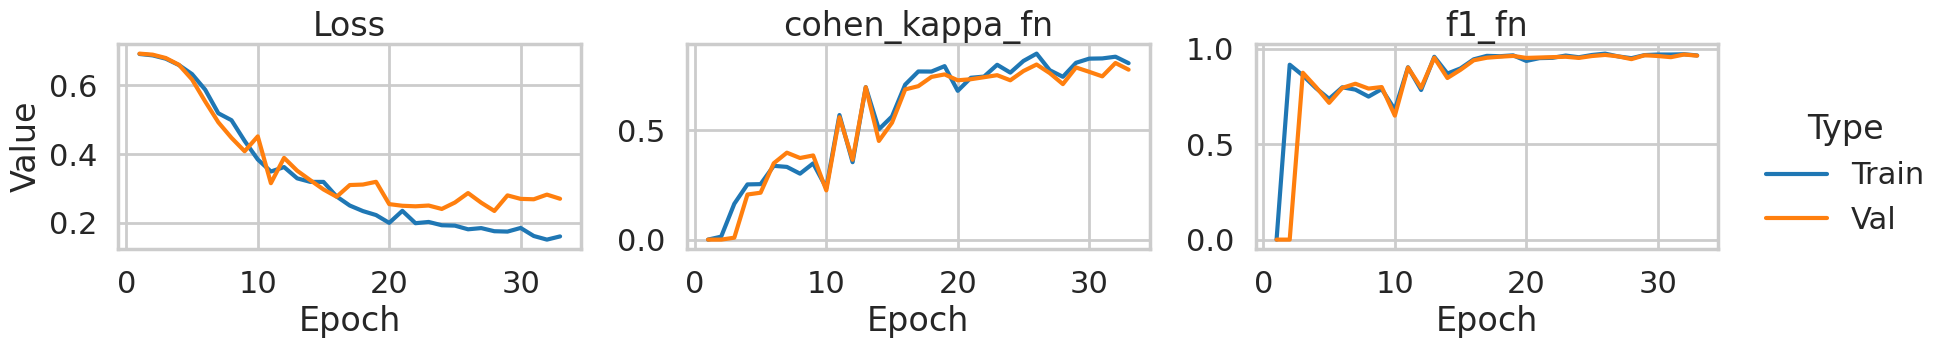

In [44]:
trainer_cnn_4.plot_epochs()

In [45]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1770 | Test cohen_kappa_fn: 0.7698 | Test f1_fn: 0.9596


#### Visualization

In [46]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

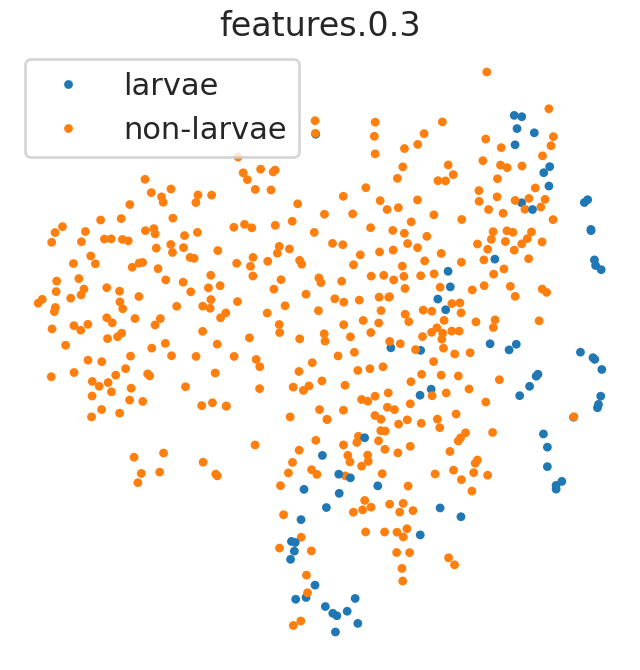

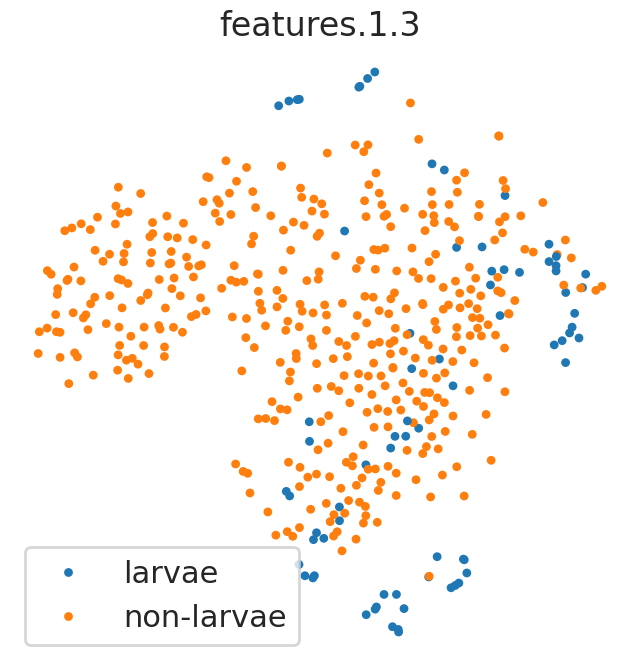

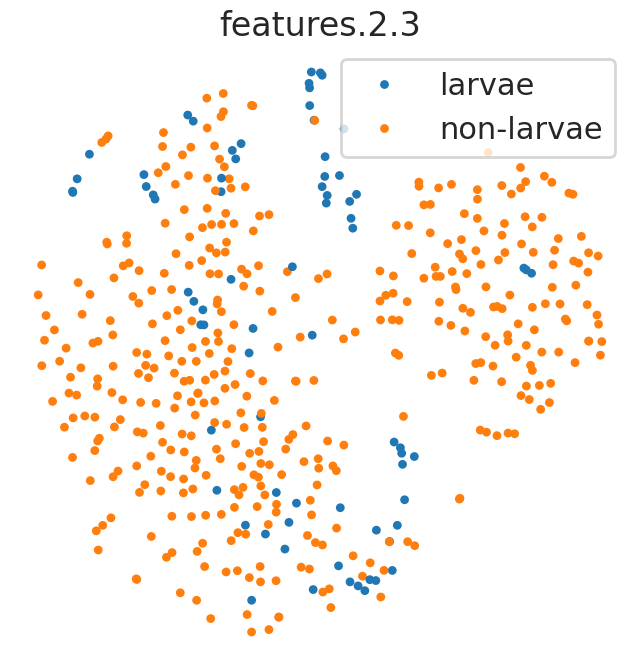

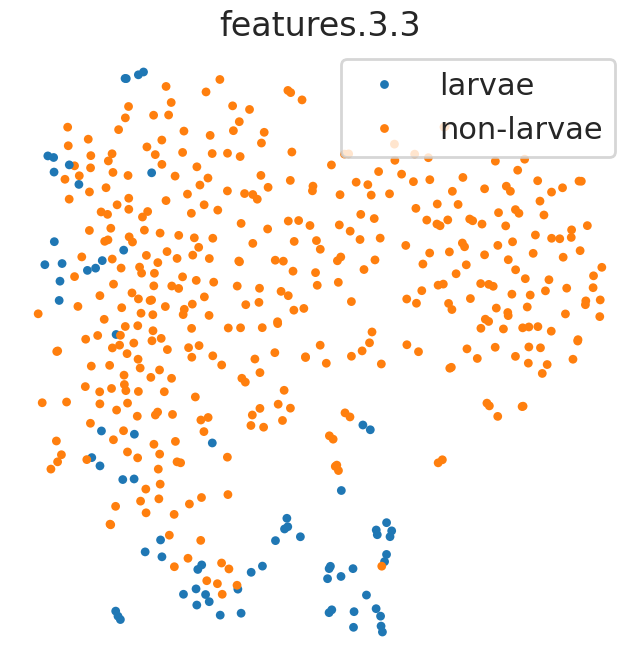

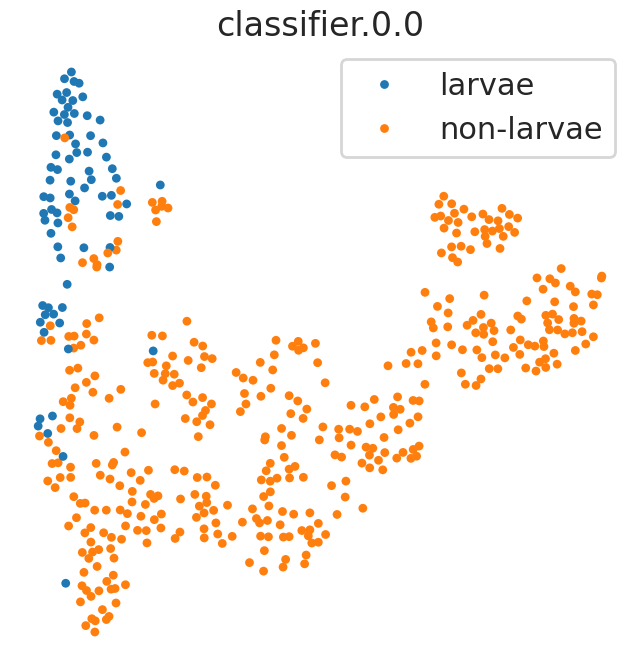

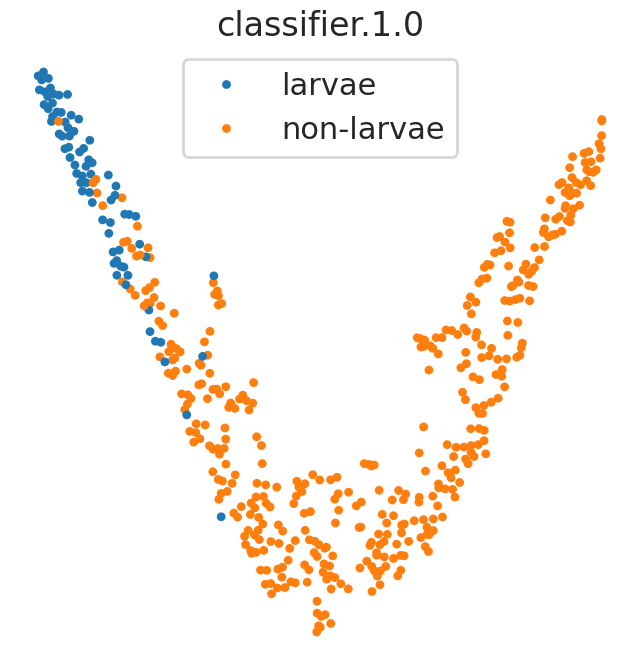

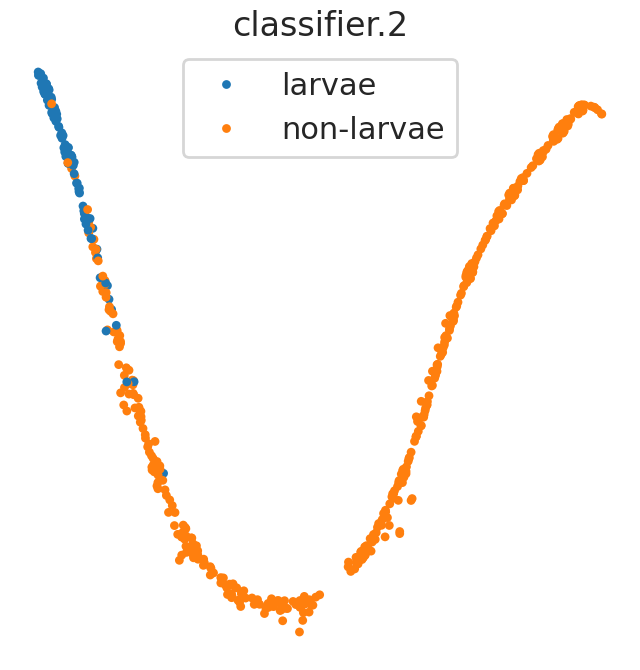

In [47]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


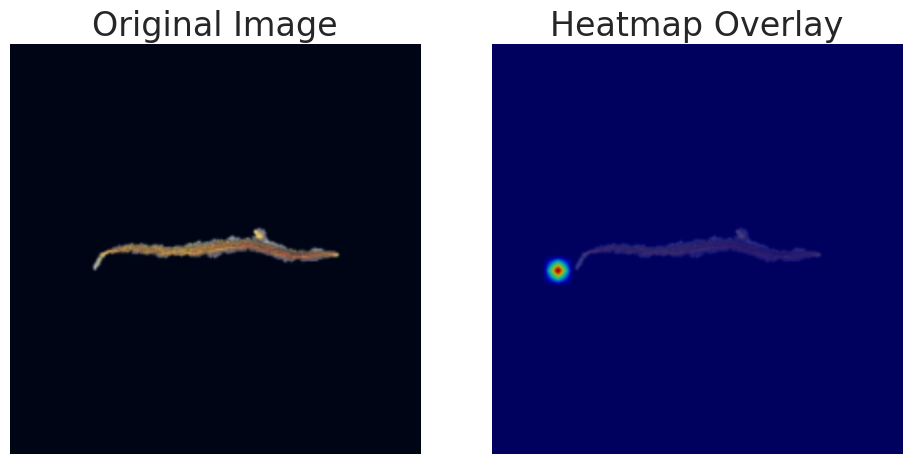

  Generating heatmap for Larvae...
  Predicted label is Larvae!


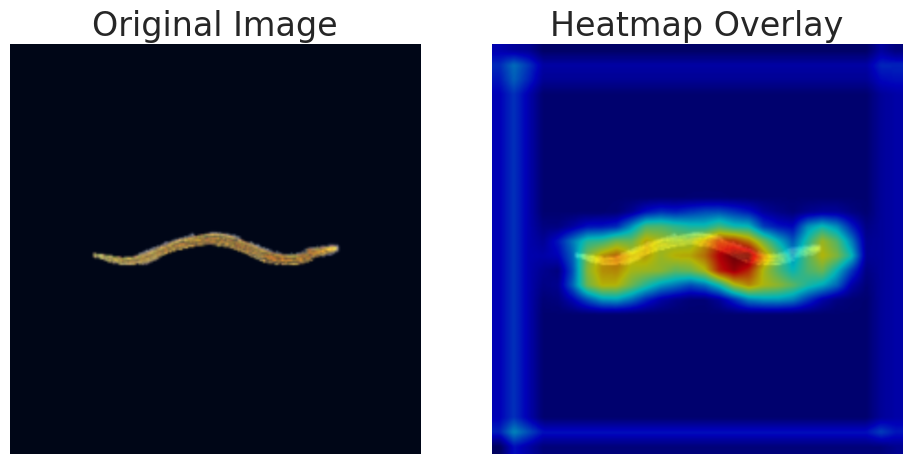

In [48]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [49]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,64,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,456
      BatchNorm2d-14          [-1, 256,

In [50]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=2e-4)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=1e-5)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [51]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6958 | Val Loss: 0.6925 | Train cohen_kappa_fn: 0.0414 | Val cohen_kappa_fn: 0.0255 | Train f1_fn: 0.2190 | Val f1_fn: 0.2046
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6863 | Val Loss: 0.6907 | Train cohen_kappa_fn: 0.0900 | Val cohen_kappa_fn: -0.0035 | Train f1_fn: 0.7481 | Val f1_fn: 0.6828
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6772 | Val Loss: 0.6810 | Train cohen_kappa_fn: 0.1203 | Val cohen_kappa_fn: 0.0588 | Train f1_fn: 0.5022 | Val f1_fn: 0.4754
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6593 | Val Loss: 0.6611 | Train cohen_kappa_fn: 0.1853 | Val cohen_kappa_fn: 0.0897 | Train f1_fn: 0.7344 | Val f1_fn: 0.7300
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6171 | Val Loss: 0.6132 | Train cohen_kappa_fn: 0.2060 | Val cohen_kappa_fn: 0.1530 | Train f1_fn: 0.6595 | Val f1_fn: 0.6456
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5559 | Val Loss: 0.5447 | Train cohen_kappa_fn: 0.2680 | Val cohen_kappa_fn: 0.2590 | Train f1_fn: 0.7366 | Val f1_fn: 0.7368
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4936 | Val Loss: 0.4773 | Train cohen_kappa_fn: 0.4654 | Val cohen_kappa_fn: 0.5046 | Train f1_fn: 0.8838 | Val f1_fn: 0.9006
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4519 | Val Loss: 0.5976 | Train cohen_kappa_fn: 0.1185 | Val cohen_kappa_fn: 0.1003 | Train f1_fn: 0.4659 | Val f1_fn: 0.4164
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3988 | Val Loss: 0.3329 | Train cohen_kappa_fn: 0.5379 | Val cohen_kappa_fn: 0.5773 | Train f1_fn: 0.8944 | Val f1_fn: 0.9062
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3637 | Val Loss: 0.3551 | Train cohen_kappa_fn: 0.4875 | Val cohen_kappa_fn: 0.3768 | Train f1_fn: 0.8631 | Val f1_fn: 0.8044
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3257 | Val Loss: 0.3248 | Train cohen_kappa_fn: 0.5736 | Val cohen_kappa_fn: 0.4753 | Train f1_fn: 0.8981 | Val f1_fn: 0.8595
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2876 | Val Loss: 0.2906 | Train cohen_kappa_fn: 0.6059 | Val cohen_kappa_fn: 0.5837 | Train f1_fn: 0.9129 | Val f1_fn: 0.9084
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2932 | Val Loss: 0.2947 | Train cohen_kappa_fn: 0.5435 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.8874 | Val f1_fn: 0.8974
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2327 | Val Loss: 0.2715 | Train cohen_kappa_fn: 0.7732 | Val cohen_kappa_fn: 0.6932 | Train f1_fn: 0.9596 | Val f1_fn: 0.9472
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2032 | Val Loss: 0.3079 | Train cohen_kappa_fn: 0.8094 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9712 | Val f1_fn: 0.9649
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2072 | Val Loss: 0.2454 | Train cohen_kappa_fn: 0.8026 | Val cohen_kappa_fn: 0.7019 | Train f1_fn: 0.9650 | Val f1_fn: 0.9492
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2094 | Val Loss: 0.2412 | Train cohen_kappa_fn: 0.6654 | Val cohen_kappa_fn: 0.5968 | Train f1_fn: 0.9287 | Val f1_fn: 0.9127
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2142 | Val Loss: 0.2504 | Train cohen_kappa_fn: 0.8127 | Val cohen_kappa_fn: 0.7475 | Train f1_fn: 0.9674 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1476 | Val Loss: 0.2639 | Train cohen_kappa_fn: 0.8214 | Val cohen_kappa_fn: 0.7969 | Train f1_fn: 0.9689 | Val f1_fn: 0.9686
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1569 | Val Loss: 0.2695 | Train cohen_kappa_fn: 0.8518 | Val cohen_kappa_fn: 0.7969 | Train f1_fn: 0.9752 | Val f1_fn: 0.9686
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1612 | Val Loss: 0.2974 | Train cohen_kappa_fn: 0.8631 | Val cohen_kappa_fn: 0.8040 | Train f1_fn: 0.9775 | Val f1_fn: 0.9706
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1456 | Val Loss: 0.3849 | Train cohen_kappa_fn: 0.8462 | Val cohen_kappa_fn: 0.7826 | Train f1_fn: 0.9763 | Val f1_fn: 0.9690
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


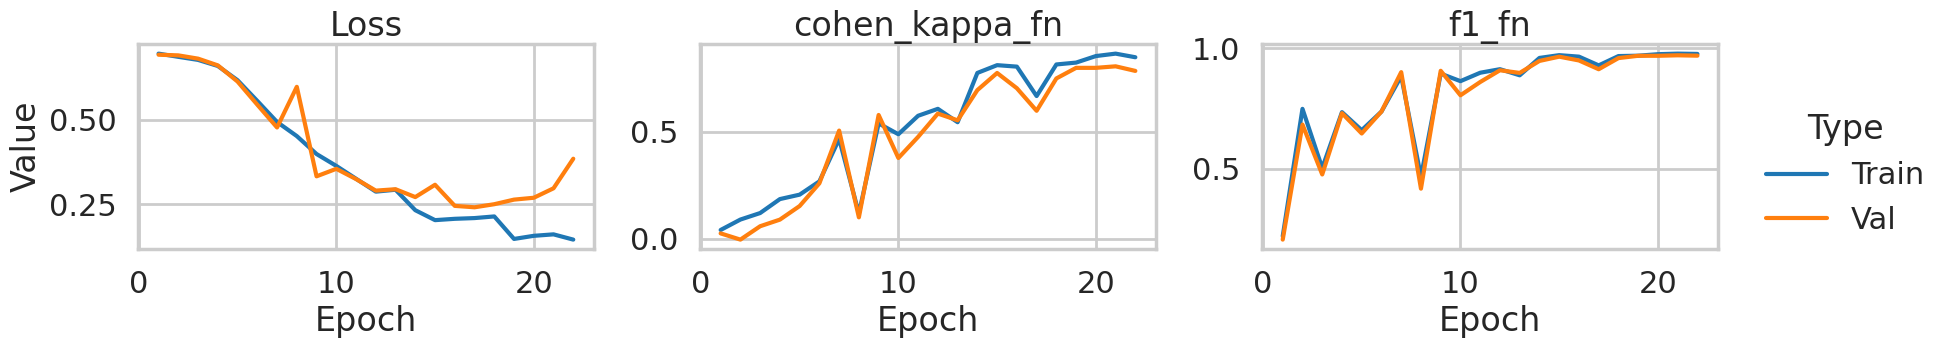

In [52]:
trainer_cnn_5.plot_epochs()

In [53]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2111 | Test cohen_kappa_fn: 0.7095 | Test f1_fn: 0.9448


#### Visualization

In [54]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

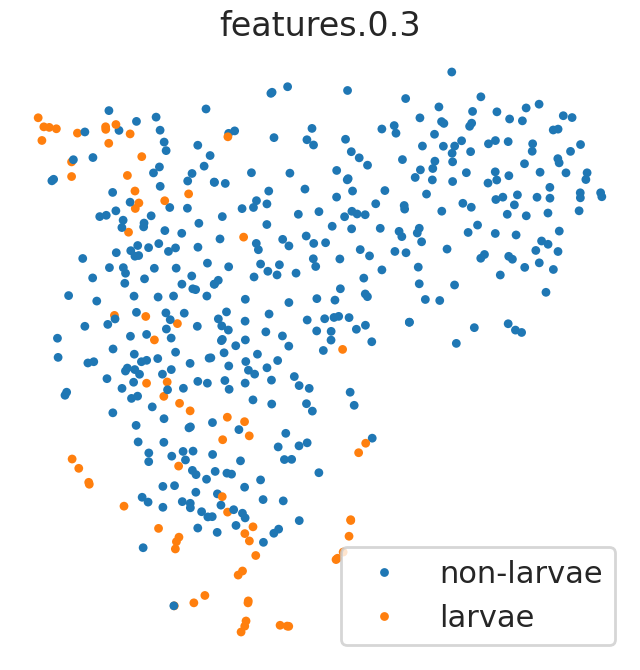

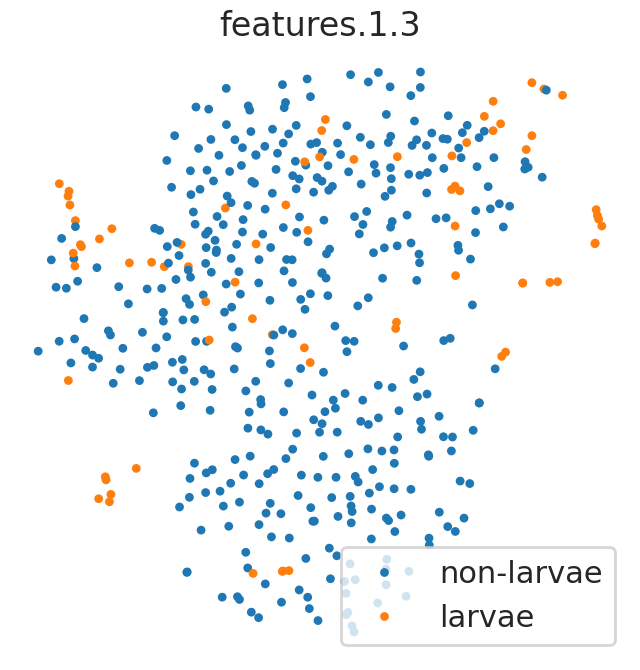

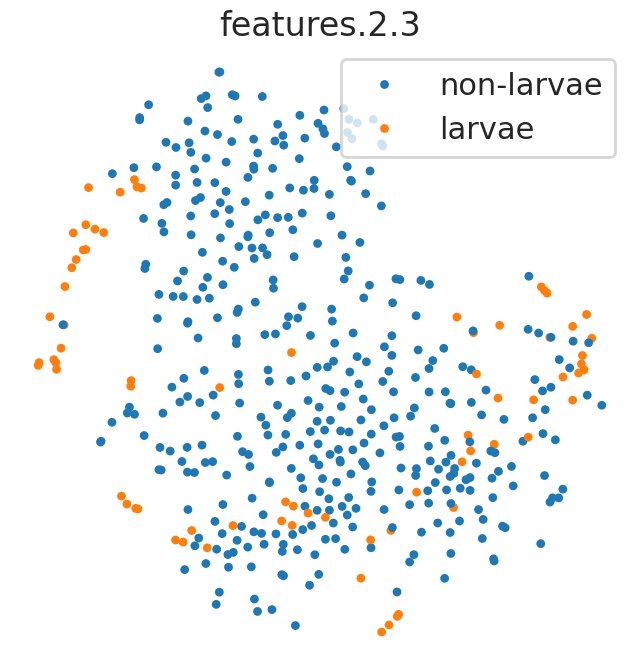

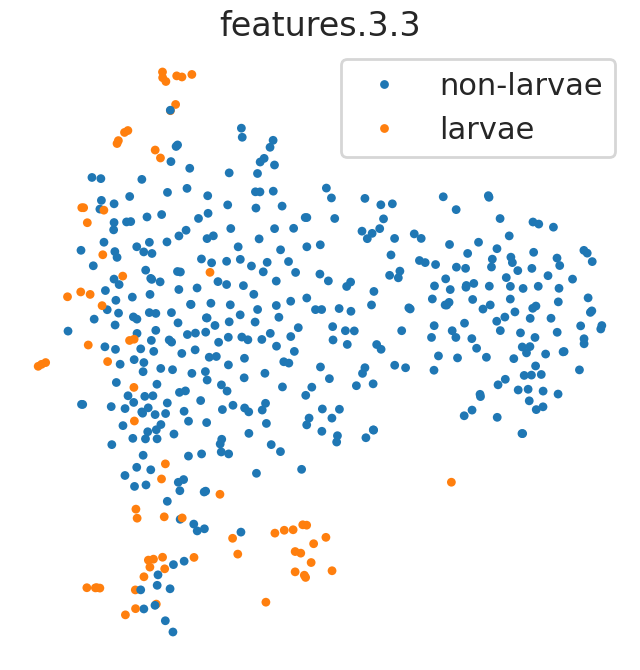

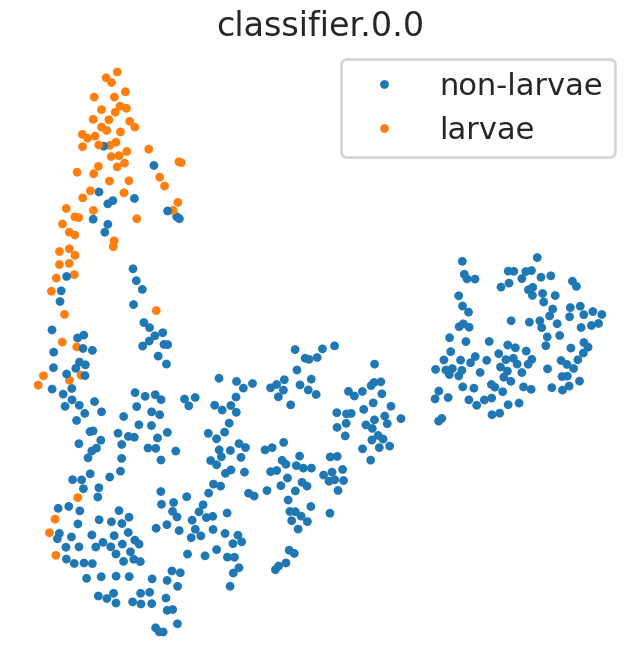

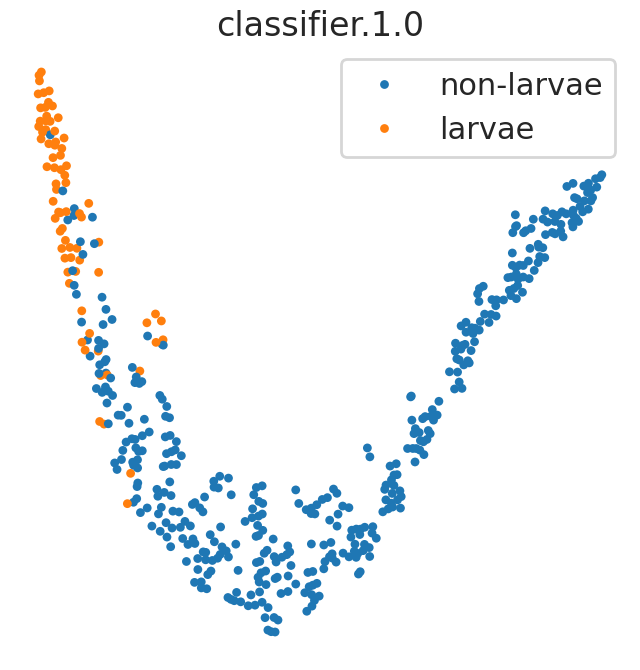

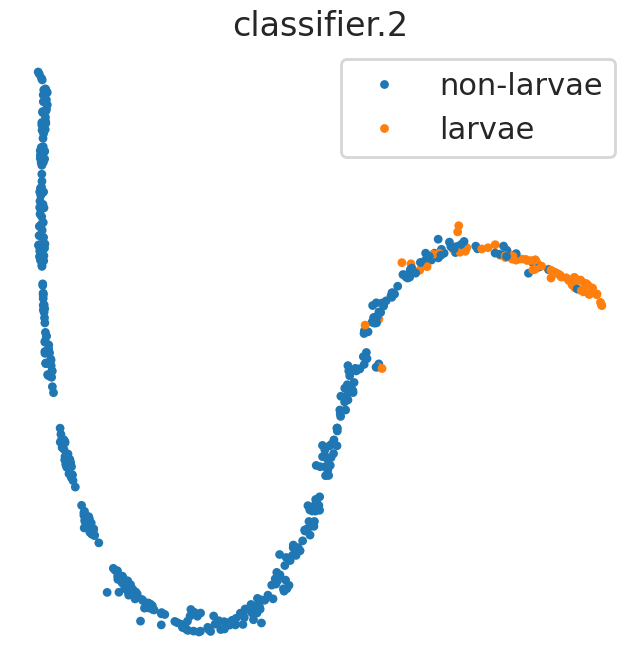

In [55]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


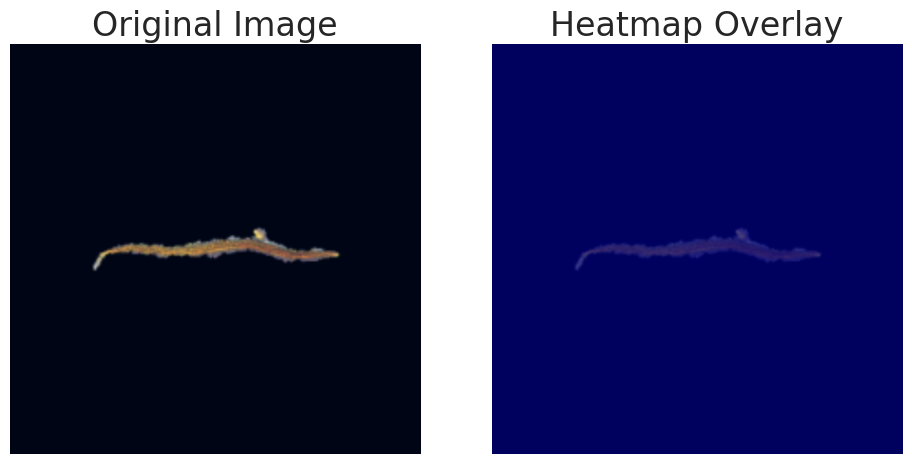

  Generating heatmap for Larvae...
  Predicted label is Larvae!


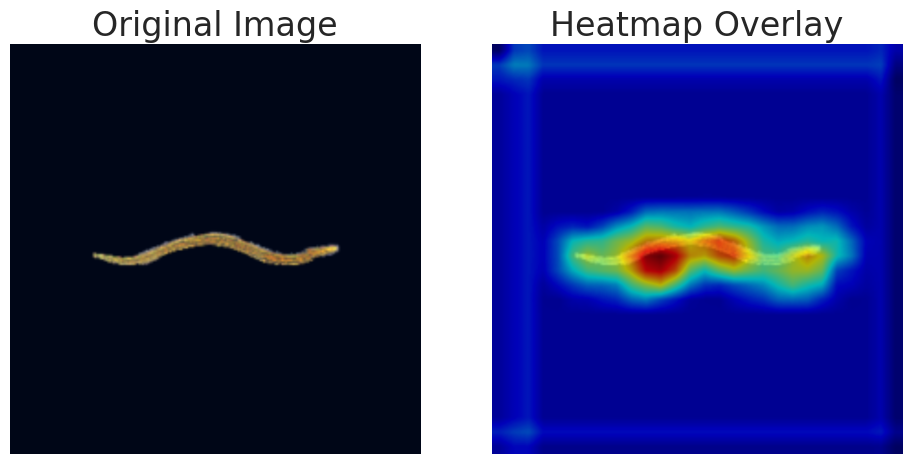

In [56]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [57]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,64,256,512],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,456
      BatchNorm2d-14          [-1, 256,

In [58]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=2e-4)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=1e-5)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [59]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6919 | Val Loss: 0.6914 | Train cohen_kappa_fn: 0.0562 | Val cohen_kappa_fn: 0.0804 | Train f1_fn: 0.2886 | Val f1_fn: 0.3587
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6794 | Val Loss: 0.6827 | Train cohen_kappa_fn: 0.0768 | Val cohen_kappa_fn: 0.0969 | Train f1_fn: 0.3592 | Val f1_fn: 0.4071
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6338 | Val Loss: 0.6424 | Train cohen_kappa_fn: 0.2655 | Val cohen_kappa_fn: 0.2627 | Train f1_fn: 0.7343 | Val f1_fn: 0.7183
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5750 | Val Loss: 0.5759 | Train cohen_kappa_fn: 0.1391 | Val cohen_kappa_fn: 0.1256 | Train f1_fn: 0.5234 | Val f1_fn: 0.4789
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4911 | Val Loss: 0.4951 | Train cohen_kappa_fn: 0.6175 | Val cohen_kappa_fn: 0.5748 | Train f1_fn: 0.9425 | Val f1_fn: 0.9355
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3895 | Val Loss: 0.4424 | Train cohen_kappa_fn: 0.2250 | Val cohen_kappa_fn: 0.2403 | Train f1_fn: 0.6607 | Val f1_fn: 0.6780
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3433 | Val Loss: 0.4174 | Train cohen_kappa_fn: 0.2448 | Val cohen_kappa_fn: 0.2968 | Train f1_fn: 0.6778 | Val f1_fn: 0.7366
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3077 | Val Loss: 0.4656 | Train cohen_kappa_fn: 0.6968 | Val cohen_kappa_fn: 0.6602 | Train f1_fn: 0.9587 | Val f1_fn: 0.9571
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3118 | Val Loss: 1.2544 | Train cohen_kappa_fn: 0.0161 | Val cohen_kappa_fn: 0.0390 | Train f1_fn: 0.0959 | Val f1_fn: 0.2060
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2622 | Val Loss: 0.2876 | Train cohen_kappa_fn: 0.7265 | Val cohen_kappa_fn: 0.7393 | Train f1_fn: 0.9493 | Val f1_fn: 0.9593
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2325 | Val Loss: 0.2657 | Train cohen_kappa_fn: 0.6265 | Val cohen_kappa_fn: 0.7197 | Train f1_fn: 0.9188 | Val f1_fn: 0.9531
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2260 | Val Loss: 0.3008 | Train cohen_kappa_fn: 0.7826 | Val cohen_kappa_fn: 0.7757 | Train f1_fn: 0.9630 | Val f1_fn: 0.9670
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2195 | Val Loss: 0.5341 | Train cohen_kappa_fn: 0.7941 | Val cohen_kappa_fn: 0.6885 | Train f1_fn: 0.9717 | Val f1_fn: 0.9607
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1833 | Val Loss: 0.2878 | Train cohen_kappa_fn: 0.8317 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9722 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1676 | Val Loss: 0.2664 | Train cohen_kappa_fn: 0.5105 | Val cohen_kappa_fn: 0.6284 | Train f1_fn: 0.8724 | Val f1_fn: 0.9261
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1705 | Val Loss: 1.3137 | Train cohen_kappa_fn: 0.5323 | Val cohen_kappa_fn: 0.3225 | Train f1_fn: 0.9471 | Val f1_fn: 0.9326
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


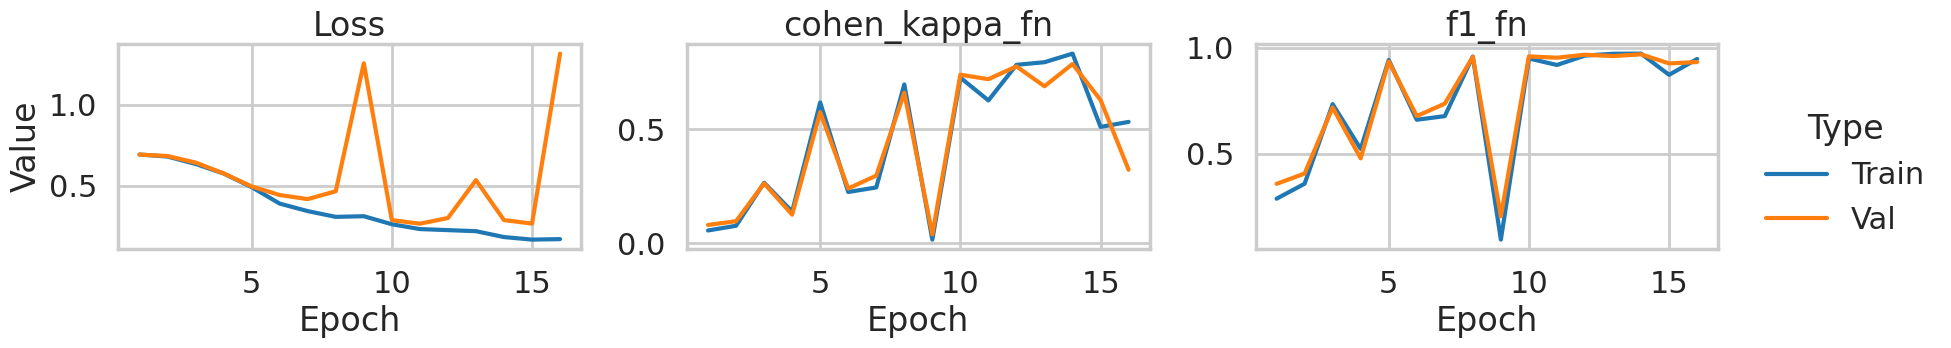

In [60]:
trainer_cnn_6.plot_epochs()

In [61]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2181 | Test cohen_kappa_fn: 0.7967 | Test f1_fn: 0.9663


#### Visualization

In [62]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

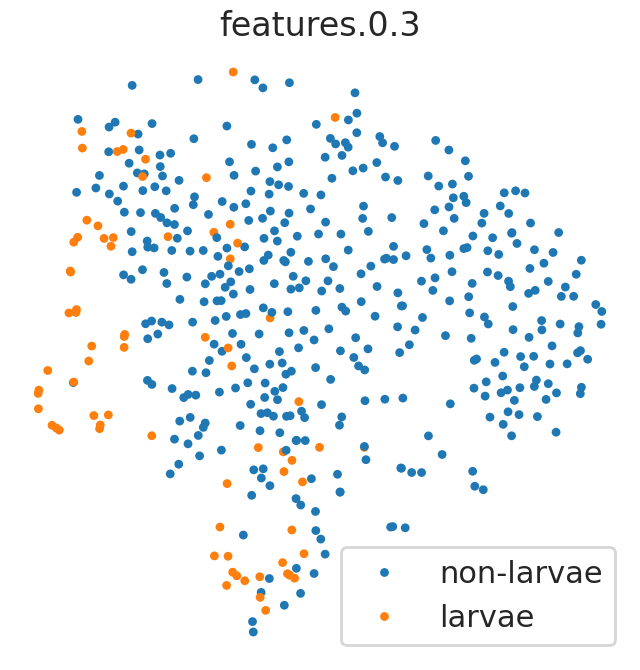

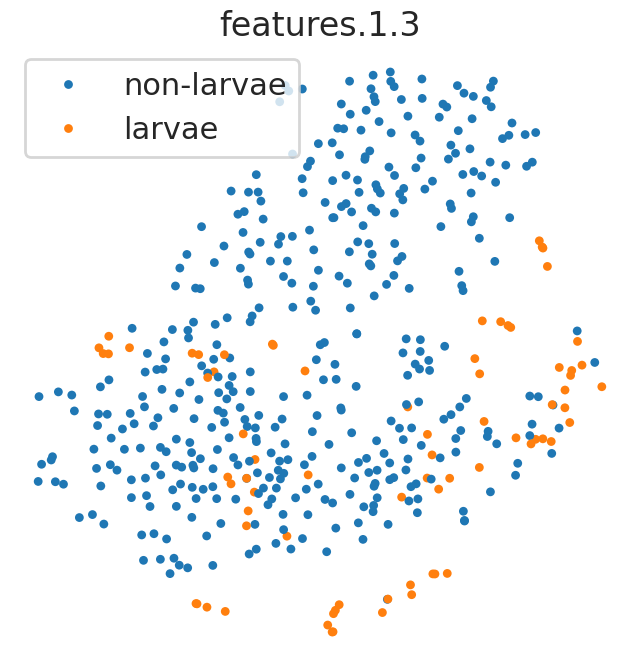

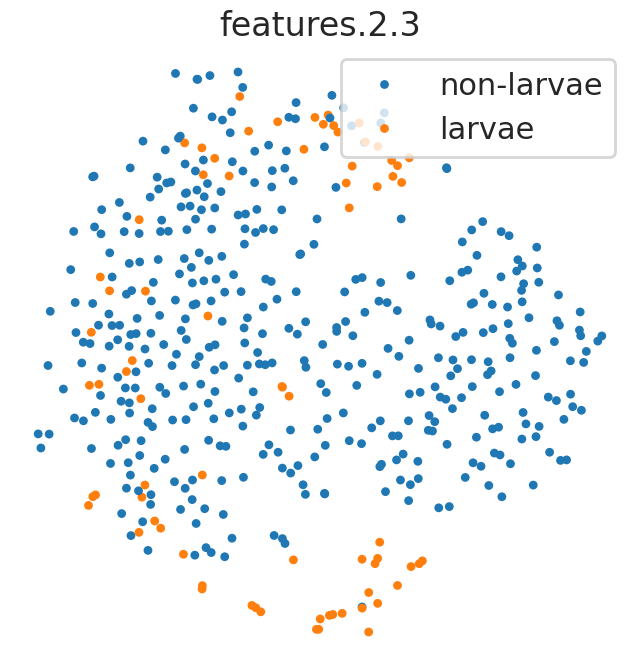

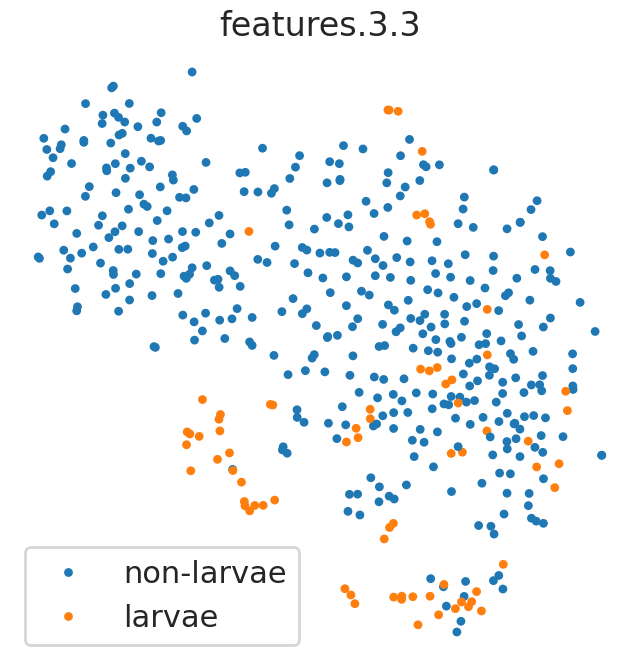

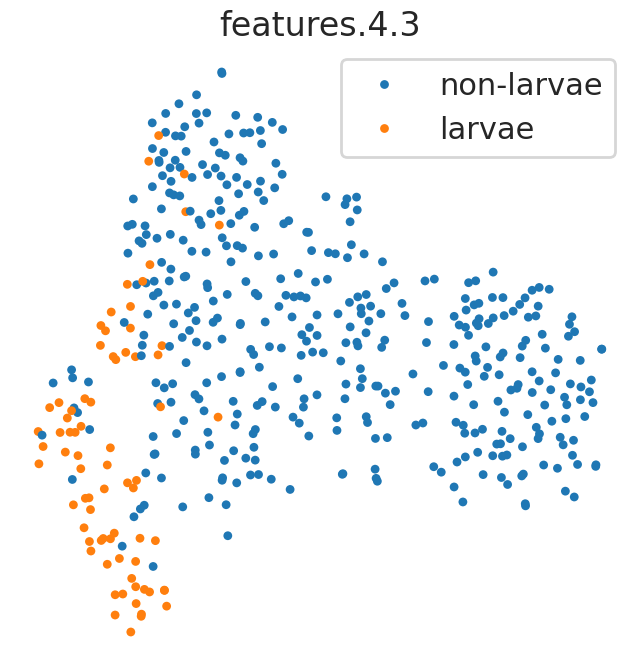

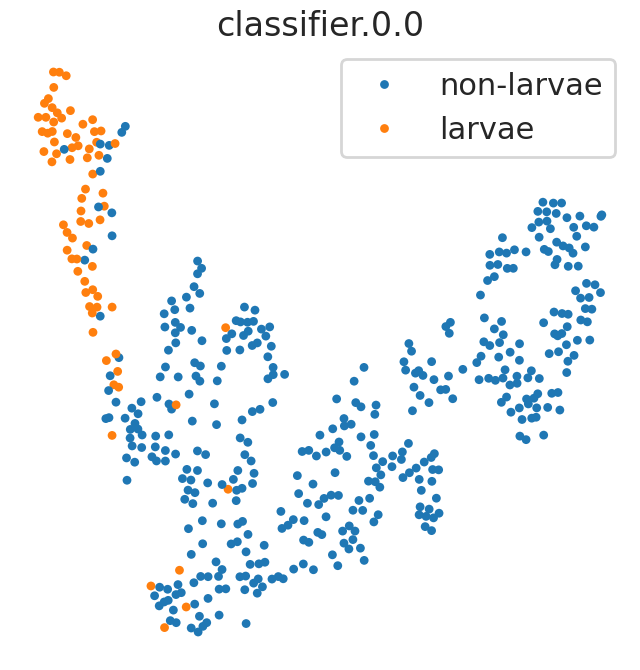

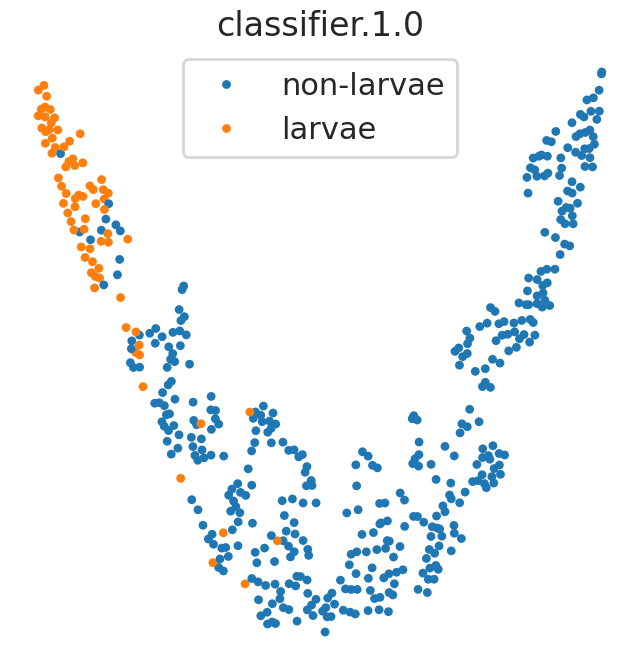

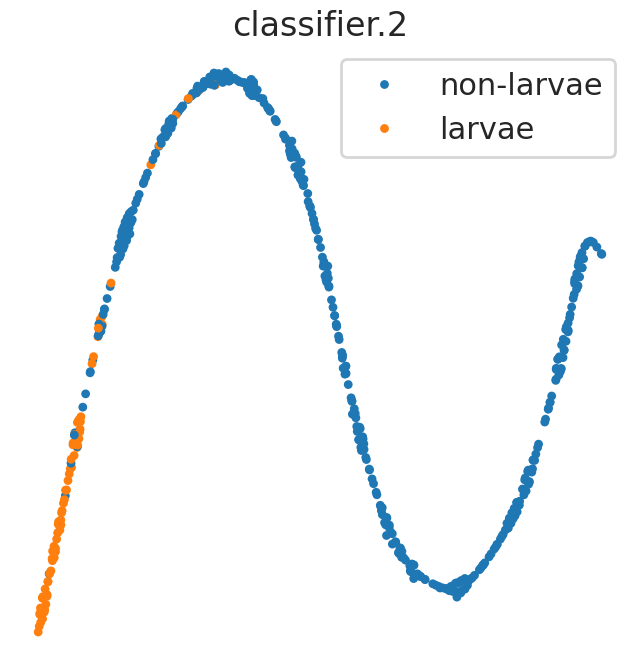

In [63]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


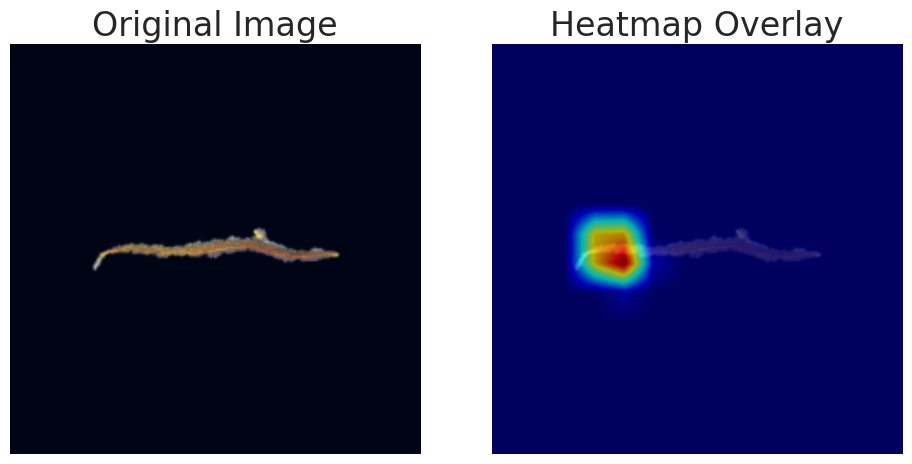

  Generating heatmap for Larvae...
  Predicted label is Larvae!


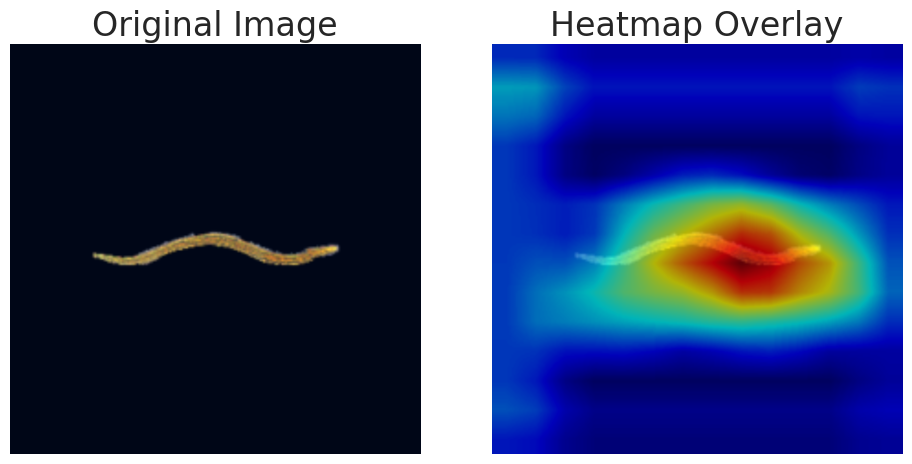

In [64]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [65]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,32,96,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          27,648
      BatchNorm2d-14           [-1, 96,

In [66]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=2e-4)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=1e-5)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [67]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6927 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6896 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6853 | Val Loss: 0.6872 | Train cohen_kappa_fn: 0.0379 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9176 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6747 | Val Loss: 0.6726 | Train cohen_kappa_fn: 0.3187 | Val cohen_kappa_fn: 0.2655 | Train f1_fn: 0.8142 | Val f1_fn: 0.7356
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6433 | Val Loss: 0.6347 | Train cohen_kappa_fn: 0.4194 | Val cohen_kappa_fn: 0.3686 | Train f1_fn: 0.8648 | Val f1_fn: 0.8087
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5933 | Val Loss: 0.6308 | Train cohen_kappa_fn: 0.2139 | Val cohen_kappa_fn: 0.1038 | Train f1_fn: 0.6541 | Val f1_fn: 0.4257
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5204 | Val Loss: 0.5402 | Train cohen_kappa_fn: 0.4588 | Val cohen_kappa_fn: 0.2810 | Train f1_fn: 0.8533 | Val f1_fn: 0.7217
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4580 | Val Loss: 0.6335 | Train cohen_kappa_fn: 0.1505 | Val cohen_kappa_fn: 0.0574 | Train f1_fn: 0.5456 | Val f1_fn: 0.2803
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3508 | Val Loss: 0.4937 | Train cohen_kappa_fn: 0.3472 | Val cohen_kappa_fn: 0.1952 | Train f1_fn: 0.7776 | Val f1_fn: 0.6082
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2842 | Val Loss: 0.8221 | Train cohen_kappa_fn: 0.1056 | Val cohen_kappa_fn: 0.0417 | Train f1_fn: 0.4339 | Val f1_fn: 0.2178
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2555 | Val Loss: 0.6827 | Train cohen_kappa_fn: 0.6251 | Val cohen_kappa_fn: 0.5393 | Train f1_fn: 0.9544 | Val f1_fn: 0.9472
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2282 | Val Loss: 0.8745 | Train cohen_kappa_fn: 0.1560 | Val cohen_kappa_fn: 0.0913 | Train f1_fn: 0.5453 | Val f1_fn: 0.4106
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2000 | Val Loss: 0.4680 | Train cohen_kappa_fn: 0.4210 | Val cohen_kappa_fn: 0.3399 | Train f1_fn: 0.8251 | Val f1_fn: 0.7840
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1692 | Val Loss: 0.3012 | Train cohen_kappa_fn: 0.8037 | Val cohen_kappa_fn: 0.6885 | Train f1_fn: 0.9649 | Val f1_fn: 0.9474
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1735 | Val Loss: 0.3026 | Train cohen_kappa_fn: 0.6357 | Val cohen_kappa_fn: 0.6107 | Train f1_fn: 0.9203 | Val f1_fn: 0.9246
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1714 | Val Loss: 0.7356 | Train cohen_kappa_fn: 0.7598 | Val cohen_kappa_fn: 0.6561 | Train f1_fn: 0.9665 | Val f1_fn: 0.9551
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1564 | Val Loss: 0.5577 | Train cohen_kappa_fn: 0.8698 | Val cohen_kappa_fn: 0.6745 | Train f1_fn: 0.9800 | Val f1_fn: 0.9546
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1392 | Val Loss: 0.3481 | Train cohen_kappa_fn: 0.8475 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9735 | Val f1_fn: 0.9649
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1286 | Val Loss: 0.3647 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9759 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


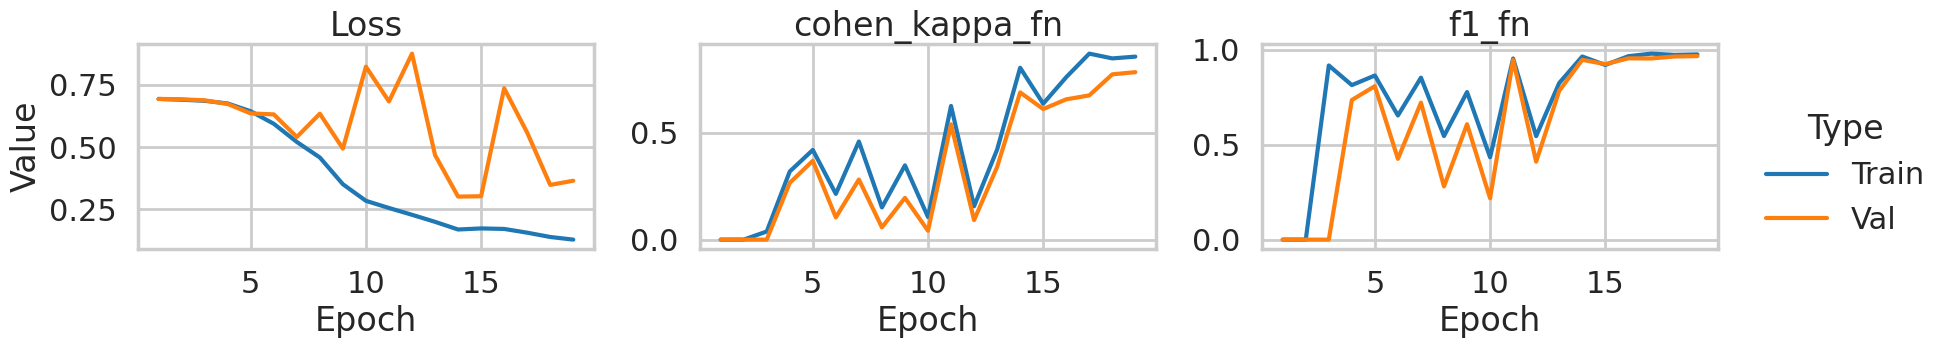

In [68]:
trainer_cnn_7.plot_epochs()

In [69]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2086 | Test cohen_kappa_fn: 0.7590 | Test f1_fn: 0.9585


#### Visualization

In [70]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

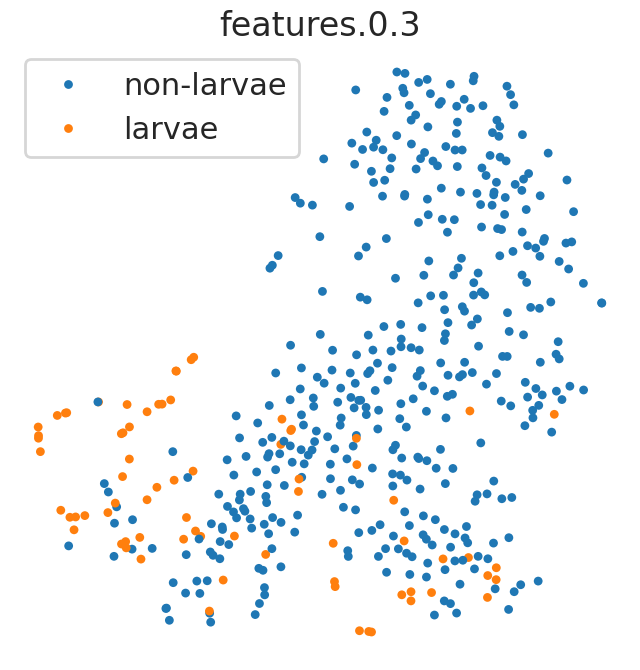

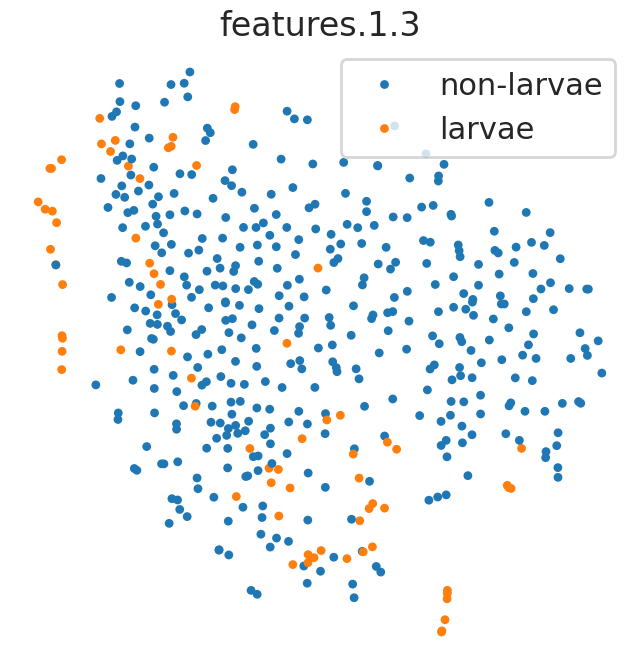

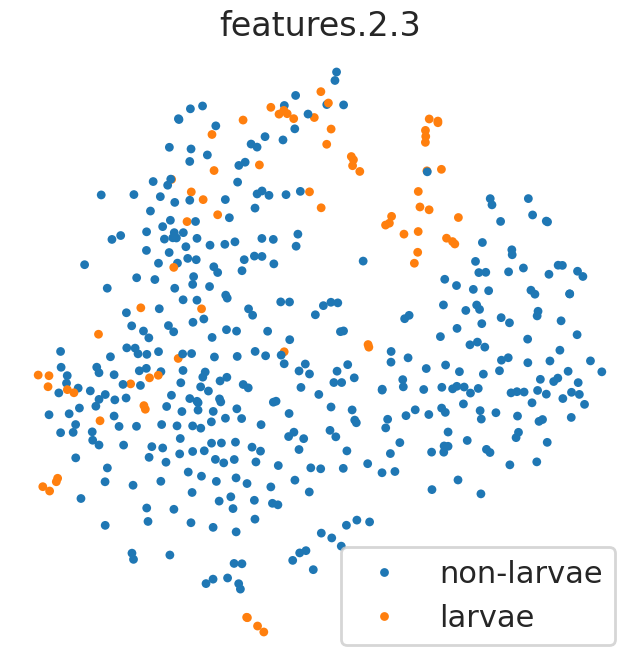

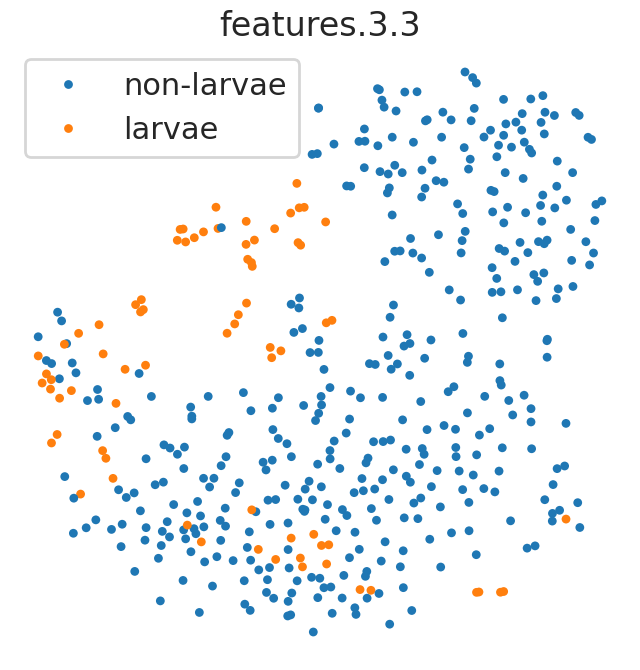

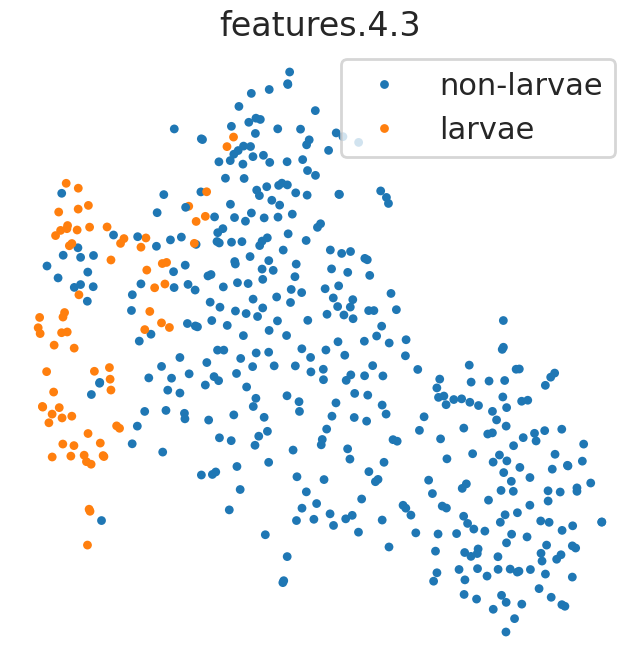

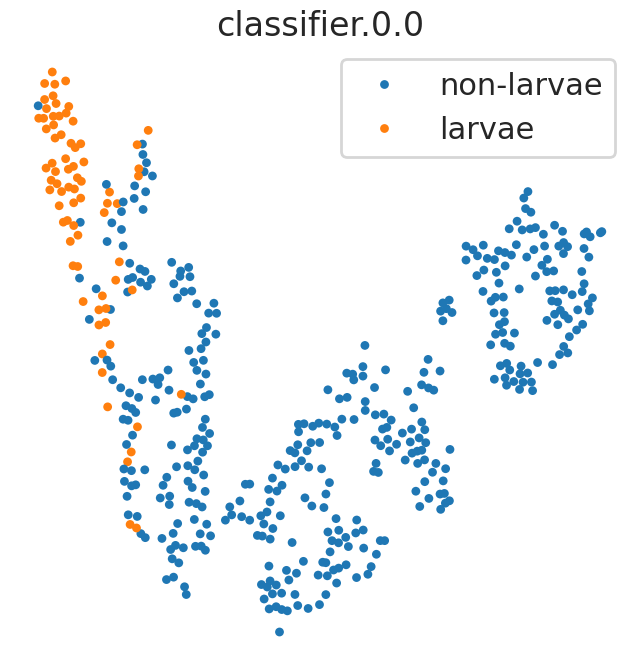

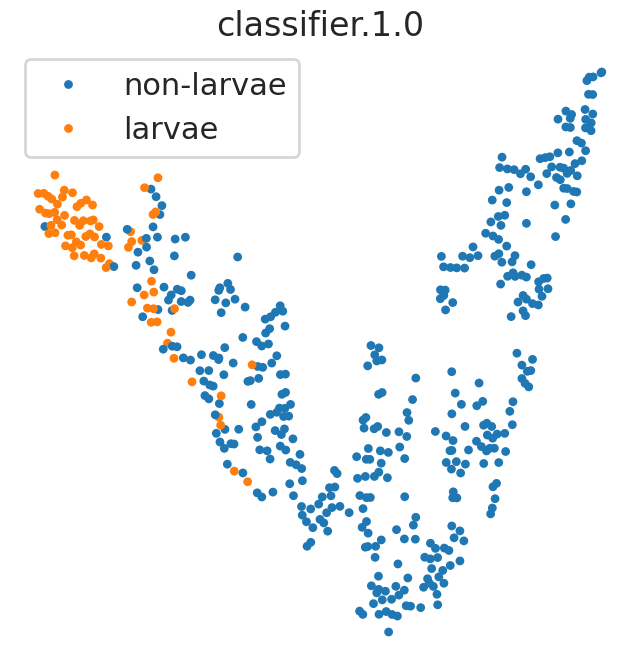

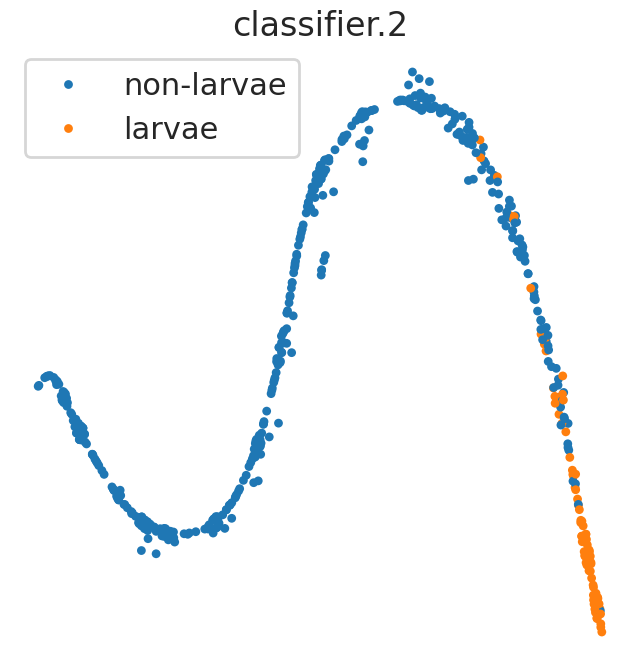

In [71]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


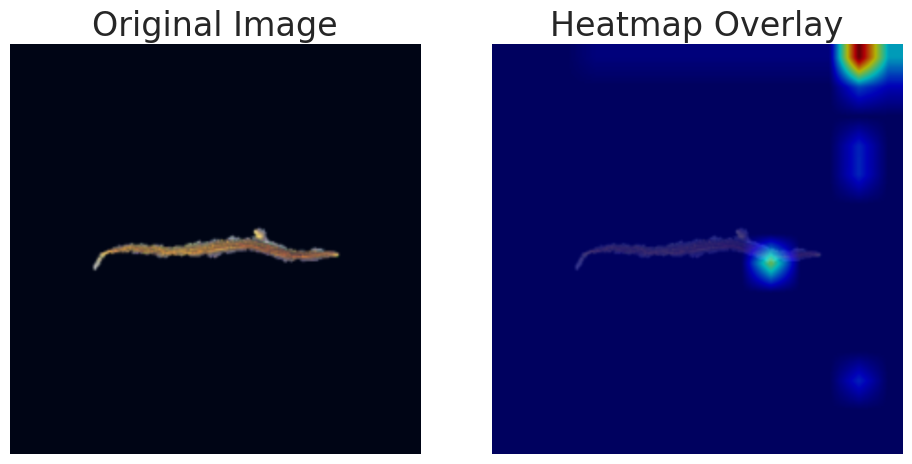

  Generating heatmap for Larvae...
  Predicted label is Larvae!


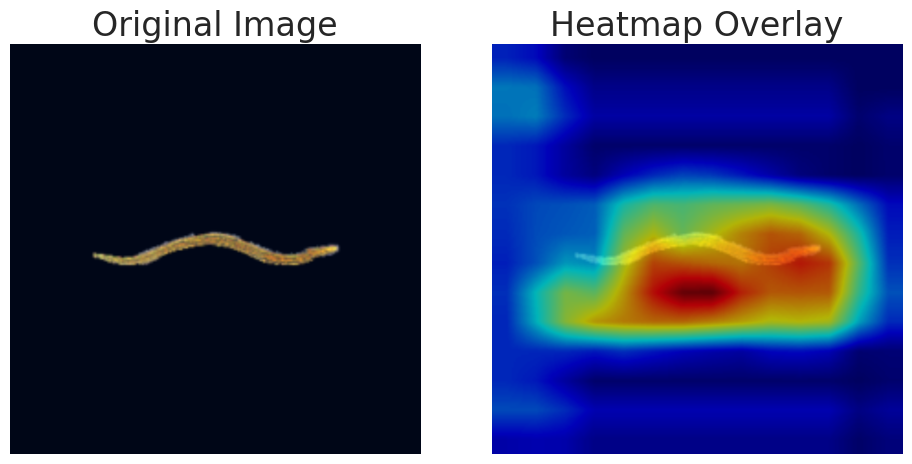

In [72]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break